# Model of auxotrophic communities with mutations in update and production rates of amino acids

We do the minimal number of fits: only estimating the increase in Pro and Trp production, and the increase in Pro uptake
Note: equation numbers refer to main text of van Vliet et al Plos Comp Bio 2022.

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from community import community
matplotlib.rc("figure", figsize=(10,5))


## Load Data and set experimentally measured parameters

In [109]:
fit_pars_0 = {} # parameters for the fit, community A not fitted
fit_pars_1 = {} # parameters for the fit, community A fitted for density
fit_pars_2 = {} # parameters for the fit, community A fitted for density and leakage
fit_pars_3 = {} # parameters for the fit, community A fitted for leakage 

In [50]:
#init dictionary to store fit parameters

#init dictionary width measured growth rates
growth_rates = {'WT':0.52, # place holder need to be measured
                'dP':0.45,
                'dT':0.52,
                'dP_trpOP':0.47, # tryptophan overproduction
                'dT_proOP':0.42, # proline overproduction
                'dP_proUp':0.18} # proline uptake mutant

#load data
df_all = pd.read_csv('community_data.csv')

#average over technical replicates
df_all['Identifier'] = df_all.apply(lambda row: f"{row['Condition']}-{row['Rep']}", axis=1)
df = df_all.groupby('Identifier').agg({'Width': 'mean', 'dT_patch': 'mean', 'dP_patch': 'mean', 'Ratio': 'mean', 'Condition': 'first', 'Rep': 'first'}).reset_index()

#add relative patch width
df['rel_range'] = df['dP_patch']/df['dT_patch']
df.head(n=9)


,Identifier,Width,dT_patch,dP_patch,Ratio,Condition,Rep,rel_range
0,A-1,120.791468,9.982812,43.561364,0.247835,A,1,4.363636
1,A-2,157.898035,7.713991,29.948438,0.274676,A,2,3.882353
2,A-3,73.479304,10.890341,31.536612,0.225064,A,3,2.895833
3,A-4,73.070673,10.436577,19.511861,0.265547,A,4,1.869565
4,A-5,103.484977,9.529048,87.803374,0.263668,A,5,9.214286
5,A-6,70.411315,9.302166,20.192507,0.279767,A,6,2.170732
6,B-1,134.280570,9.075284,4.991406,0.463751,B,1,0.550000
7,B-2,169.978639,160.632528,83.265732,0.410185,B,2,0.518362
8,B-3,280.877680,7.487109,11.117223,0.356883,B,3,1.484848


In [132]:
df_mean = df.groupby('Condition')[['Width', 'dT_patch', 'dP_patch', 'Ratio', 'rel_range']].mean().reset_index()
df_mean.head(n=9)

,Condition,Width,dT_patch,dP_patch,Ratio,rel_range
0,A,99.855962,9.642489,38.759026,0.259426,4.066068
1,B,165.937762,34.599521,22.536955,0.419124,0.940167
2,C,-0.490552,8.281197,19.247165,0.590971,2.396698
3,D,298.223025,9.188725,5.445170,0.625701,0.656216
4,E,803.814899,119.566868,491.048497,0.192119,4.065417
5,F,854.308375,134.352018,147.889317,0.387379,1.109466
6,G,846.470840,113.478865,189.711251,0.409993,1.658255
7,H,873.030570,133.066353,174.321082,0.403510,1.297801
8,WT,1083.484242,192.774160,782.705439,0.542899,3.619530


In [135]:
df_cv = df.groupby('Condition')[['Width', 'dT_patch', 'dP_patch', 'Ratio', 'rel_range']].std().reset_index() 
df_cv = df_cv[['Width', 'dT_patch', 'dP_patch', 'Ratio', 'rel_range']] / df_mean[['Width', 'dT_patch', 'dP_patch', 'Ratio', 'rel_range']]
df_cv.head(n=9)


,Width,dT_patch,dP_patch,Ratio,rel_range
0,0.349804,0.115030,0.660145,0.077417,0.663693
1,0.409066,1.786732,1.361507,0.092874,0.508941
2,-45.550376,0.143672,0.962493,0.037607,0.942641
3,0.177079,0.336655,0.114867,0.023122,0.380720
4,0.055162,0.166711,1.078961,0.306925,0.984688
5,0.051664,0.190307,0.222851,0.108922,0.198265
6,0.068042,0.165026,0.492915,0.215813,0.465320
7,0.059639,0.107861,0.539521,0.189878,0.465596
8,0.071996,0.348009,1.031594,0.108644,0.803884


In [81]:
def plot_growth_profile(community):
    ''' Plot growth profiles of the community
    
    Parameters:
    community: community object
    
    Returns:
    fig: figure object
    
    '''

    #set colors
    yellow = np.array([246,219,147])/255
    blue = np.array([42,86,152])/255
    
    #calculate growth profiles
    x_vec = np.linspace(0,60,1000)
    community.calc_growth_profiles(x_vec)
    #community.calc_growth_profiles_sectors()
    
    #normalize to WT growth rate
    muWT = community.mu0 * 3600
    
    #plot growth profiles
    fig,ax = plt.subplots(1,1,figsize=(5,5))
    ax.plot(community.x_T, community.mu_profile_T/muWT, color=yellow, label='dT')
    ax.plot(community.x_P, community.mu_profile_P/muWT, color=blue, label='dP')
    
    # ax.plot(community.x_sector_T, community.mu_profile_sector_T/muWT, color=yellow, label='dT sect', linestyle='--')
    # ax.plot(community.x_sector_P, community.mu_profile_sector_P/muWT, color=blue, label='dP sect', linestyle='--')    
    
    ax.set_xlabel('Position (um)')
    ax.set_ylabel('Growth rate relative to WT')
    ax.set_ylim(0,1)
    
    #add reference lines
    plt.axvline(x=0, color='k', linestyle='-')
    plt.axvline(x=community.rangeP, color=blue, linestyle=':')
    plt.axvline(x=-community.rangeT, color=yellow, linestyle=':')

    return fig

def report_data(df, condition):
    df_sum = df[df['Condition']==condition]
    
    rel_growth = df_sum["Width"].mean()  / df.loc[df['Condition']=='WT']['Width'].mean() 
    sector_ratio = np.mean(df_sum['dP_patch'] / df_sum['dT_patch'])
    
    print(f"Ex. C{condition:s}: f(dT) = {df_sum['Ratio'].mean() :.2f}, rel. growth = {rel_growth:.2f}, sectors dP = {df_sum['dP_patch'].mean() :.2f}um, sectors dT = {df_sum['dT_patch'].mean() :.2f}um, sector ratio = {sector_ratio:.2f}")
    return None

In [80]:
df.groupby('Condition').std()/df.groupby('Condition').mean()

/var/folders/bt/bfw962p91rjdg_tcsz3dh95w0000gn/T/ipykernel_5836/2707729760.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.std is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df.groupby('Condition').std()/df.groupby('Condition').mean()
/var/folders/bt/bfw962p91rjdg_tcsz3dh95w0000gn/T/ipykernel_5836/2707729760.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df.groupby('Condition').std()/df.groupby('Condition').mean()


,Width,dT_patch,dP_patch,Ratio,Rep,rel_range
Condition,,,,,,
A,0.349804,0.115030,0.660145,0.077417,0.534522,0.663693
B,0.409066,1.786732,1.361507,0.092874,0.534522,0.508941
C,-45.550376,0.143672,0.962493,0.037607,0.534522,0.942641
D,0.177079,0.336655,0.114867,0.023122,0.534522,0.380720
E,0.055162,0.166711,1.078961,0.306925,0.534522,0.984688
F,0.051664,0.190307,0.222851,0.108922,0.534522,0.198265
G,0.068042,0.165026,0.492915,0.215813,0.534522,0.465320
H,0.059639,0.107861,0.539521,0.189878,0.534522,0.465596
WT,0.071996,0.348009,1.031594,0.108644,0.534522,0.803884


___
## Check Community A (dT + dP)

Frequency dT = 0.26
Clustering dT = 0.90, Clustering dP = 0.99
Growth relative to WT = 0.17
Growth defect spatial community = 0.94
mu_max dP = 0.34, mu_max dT = 0.13
range dP = 12.69um, range dT = 2.55um, range dP/dT = 4.97
Exp. Community A: f(dT) = 0.26, rel. growth = 0.09, sectors dT = 9.64um, sectors dP = 38.76um,  sector ratio = 4.02


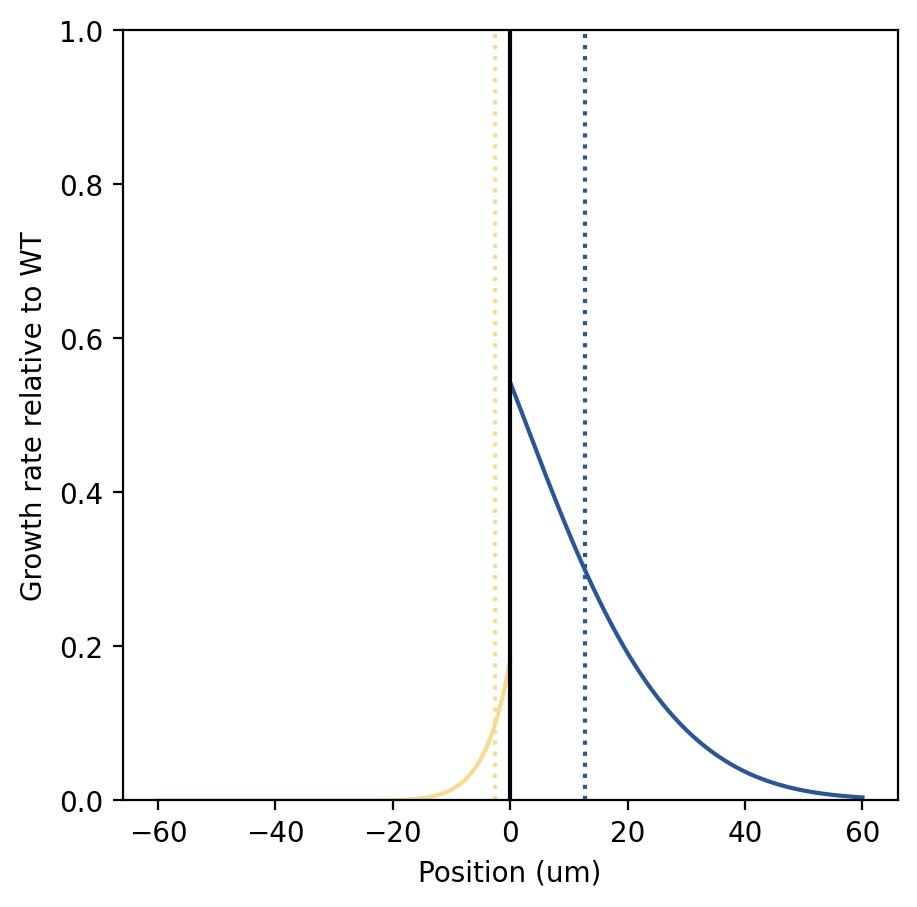

In [28]:
community_A = community(mu_WT=growth_rates['WT'], mu_dT=growth_rates['dT'], mu_dP=growth_rates['dP'])
community_A.report_properties()
fig = plot_growth_profile(community_A)
report_data(df, 'A')

---

### Fit cost function

In [69]:
def fit_par(x, L2_norm):
    ''' Find x value of minimum L2 norm
    
    Parameters:
    x: x data
    L2_norm: L2 norm
    
    Returns:
    x value of minimum L2 norm
    '''
    min_idx = np.argmin(L2_norm)
    return x[min_idx]

def fit_1D(x, y_data, y_model):
    ''' Fit 1D data'''
    L2_norm = (y_model - y_data)**2
    min_idx = np.argmin(L2_norm)
    
    fitted_x = x[min_idx]    
    fig, axs = plt.subplots(1,1,figsize=(5,3))
    
    axs.plot(x, y_model, label='model')
    axs.plot(x, np.ones_like(x) * y_data.mean(), label='data')
    axs.axvline(x=fitted_x, color='k', linestyle='--')
    
    return (fitted_x, min_idx)     

def fit_2D(x, y, z1, z2, z1_data, z2_data, log_scale=False):
      
    delta1 = (z1 - z1_data)/z1_data
    delta2 = (z2 - z2_data)/z2_data
    L2_norm_comb = np.log10(delta1**2 + delta2**2)

    idx_y, idx_x = np.unravel_index(np.argmin(L2_norm_comb), L2_norm_comb.shape)
    xfit = x[idx_x]
    yfit = y[idx_y]

    fig,axs = plt.subplots(1,3,figsize=(15,5))

    im0 = axs[0].imshow(z1, extent=[x.min(), x.max(), y.min(), y.max()], origin='lower',aspect='auto')
    fig.colorbar(im0, ax=axs[0])
    axs[0].contour(x, y, z1, levels=[z1_data.mean()], colors='r')
    axs[0].contour(x, y, z2, levels=[z2_data.mean()], colors='m')
    axs[0].axvline(x=xfit, color='k', linestyle='--')
    axs[0].axhline(y=yfit, color='k', linestyle='--')
    
    #set axis to log scale
    if log_scale:
        axs[0].set_xscale('log')
        axs[0].set_yscale('log')

    im1 = axs[1].imshow(z2, extent=[x.min(), x.max(), y.min(), y.max()], origin='lower',aspect='auto')
    fig.colorbar(im1, ax=axs[1])
    axs[1].contour(x, y, z1, levels=[z1_data.mean()], colors='m')
    axs[1].contour(x, y, z2, levels=[z2_data.mean()], colors='r')
    axs[1].axvline(x=xfit, color='k', linestyle='--')
    axs[1].axhline(y=yfit, color='k', linestyle='--')
    
    #set axis to log scale
    if log_scale:
        axs[1].set_xscale('log')
        axs[1].set_yscale('log')

    im2 = axs[2].imshow(L2_norm_comb, origin='lower', extent=[x.min(), x.max(), y.min(), y.max()], aspect='auto')
    fig.colorbar(im2, ax=axs[2])
    axs[2].axvline(x=xfit, color='k', linestyle='--')
    axs[2].axhline(y=yfit, color='k', linestyle='--')
    
    #set axis to log scale
    if log_scale:
        axs[2].set_xscale('log')
        axs[2].set_yscale('log')

    return (xfit, yfit)

---
## Option 1: Fit density based on community A

We fit density based on sector size from WT community, we assume that the correlation length is similar to interaction length 

Frequency dT = 0.28
Clustering dT = 0.99, Clustering dP = 1.00
Growth relative to WT = 0.18
Growth defect spatial community = 0.99
mu_max dP = 0.34, mu_max dT = 0.13
range dP = 42.44um, range dT = 8.54um, range dP/dT = 4.97
Ex. CA: f(dT) = 0.26, rel. growth = 0.09, sectors dP = 38.76um, sectors dT = 9.64um, sector ratio = 4.07


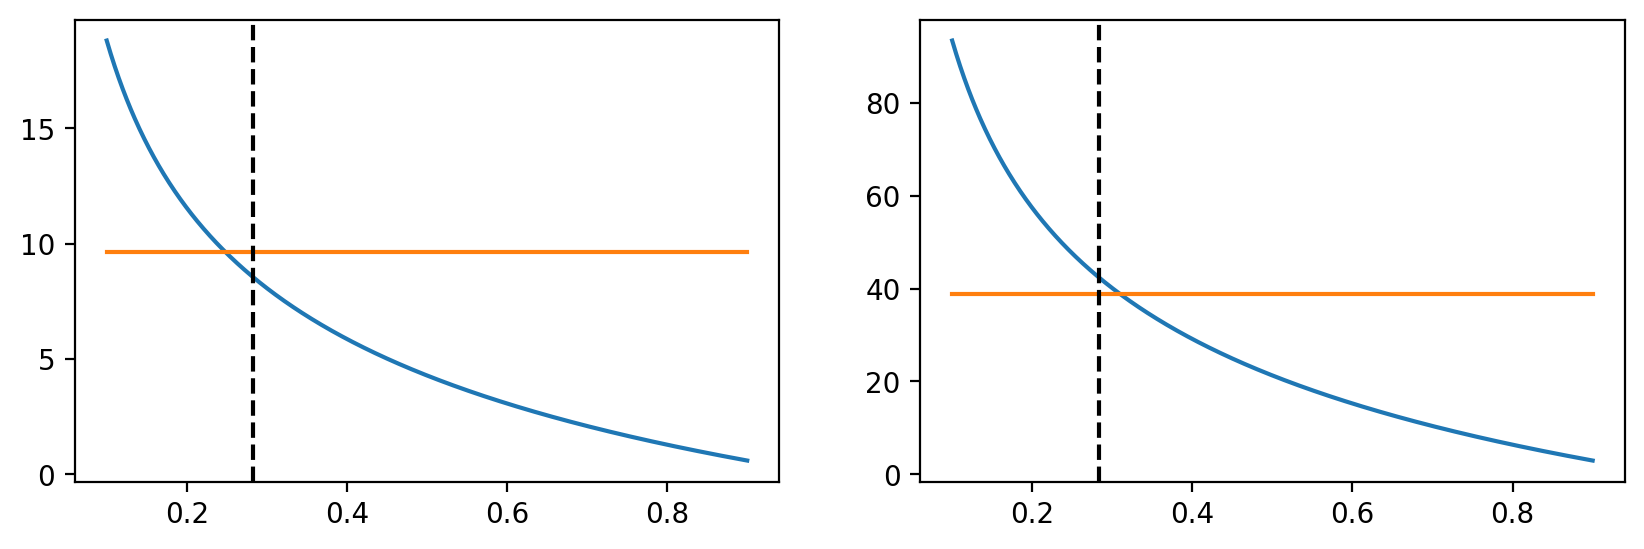

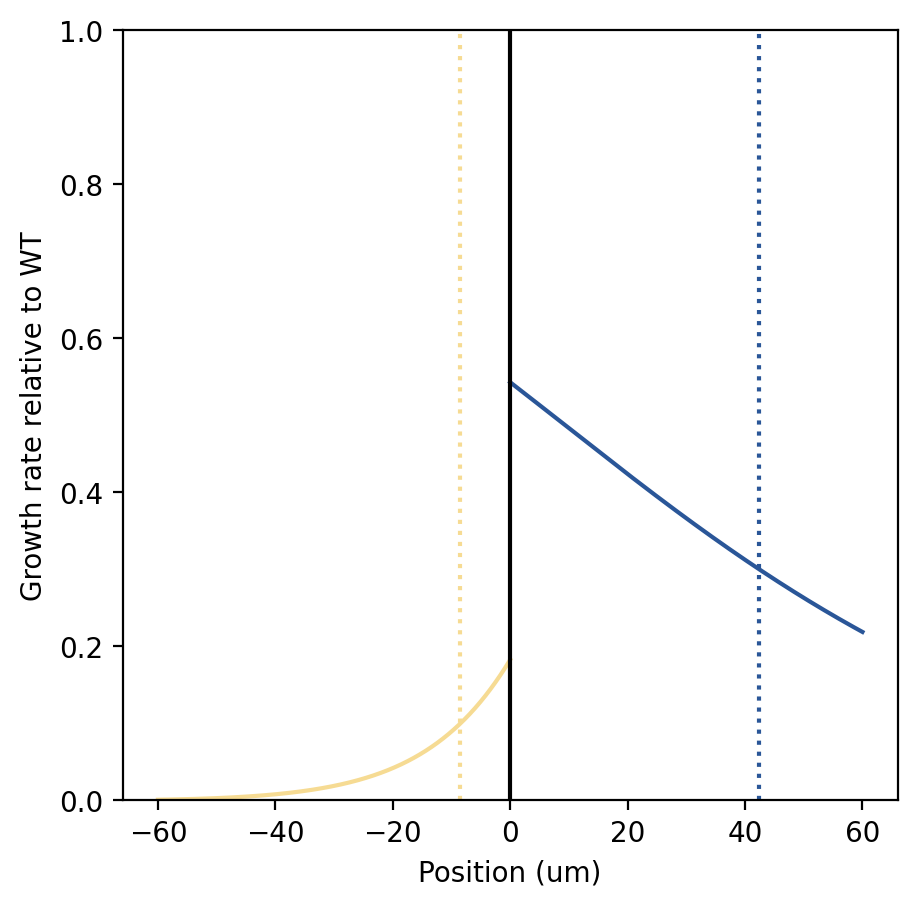

In [111]:
#set baseline community
rho_vec = np.linspace(0.1,0.9,801)
community_A_fit = community(rho=rho_vec, mu_WT=growth_rates['WT'], mu_dT=growth_rates['dT'], mu_dP=growth_rates['dP'])
def_com = community()

#calculate average sector width
est_rangeT = df.loc[df['Condition']=='A']['dT_patch'].mean() 
est_rangeP = df.loc[df['Condition']=='A']['dP_patch'].mean()

#calcualte combined normalized error
L2_dP = (community_A_fit.rangeT - est_rangeT)/est_rangeT
L2_dT = (community_A_fit.rangeP - est_rangeP)/est_rangeP
L2_norm = L2_dP**2 + L2_dT**2
rho_opt = fit_par(rho_vec, L2_norm)

fit_pars_0['rho'] = def_com.rho
fit_pars_1['rho'] = rho_opt
fit_pars_2['rho'] = rho_opt
fit_pars_3['rho'] = def_com.rho

#plot fit results
fig, axs = plt.subplots(1,2,figsize=(10,3))
axs[0].plot(rho_vec, community_A_fit.rangeT, label='model')
axs[0].plot(rho_vec, np.ones_like(rho_vec) * np.mean(est_rangeT), label='data')
axs[0].axvline(x=rho_opt, color='k', linestyle='--')

axs[1].plot(rho_vec, community_A_fit.rangeP, label='model')
axs[1].plot(rho_vec, np.ones_like(rho_vec) * np.mean(est_rangeP), label='data')
axs[1].axvline(x=rho_opt, color='k', linestyle='--')

#plot community results
community_A_fit = community(rho=fit_pars['rho'], mu_WT=growth_rates['WT'], mu_dT=growth_rates['dT'], mu_dP=growth_rates['dP'])
community_A_fit.report_properties()
fig = plot_growth_profile(community_A_fit)
report_data(df, 'A')

---

## Option 2: Fit leakage rates based on community A


w/ rho: Pro leakage = 1.85e-06 (original = 1.59e-05), Trp leakage = 1.32e-07 (original = 6.04e-07)
no rho: Pro leakage = 1.92e-06 (original = 1.59e-05), Trp leakage = 1.59e-07 (original = 6.04e-07)
Ex. CA: f(dT) = 0.26, rel. growth = 0.09, sectors dP = 38.76um, sectors dT = 9.64um, sector ratio = 4.07


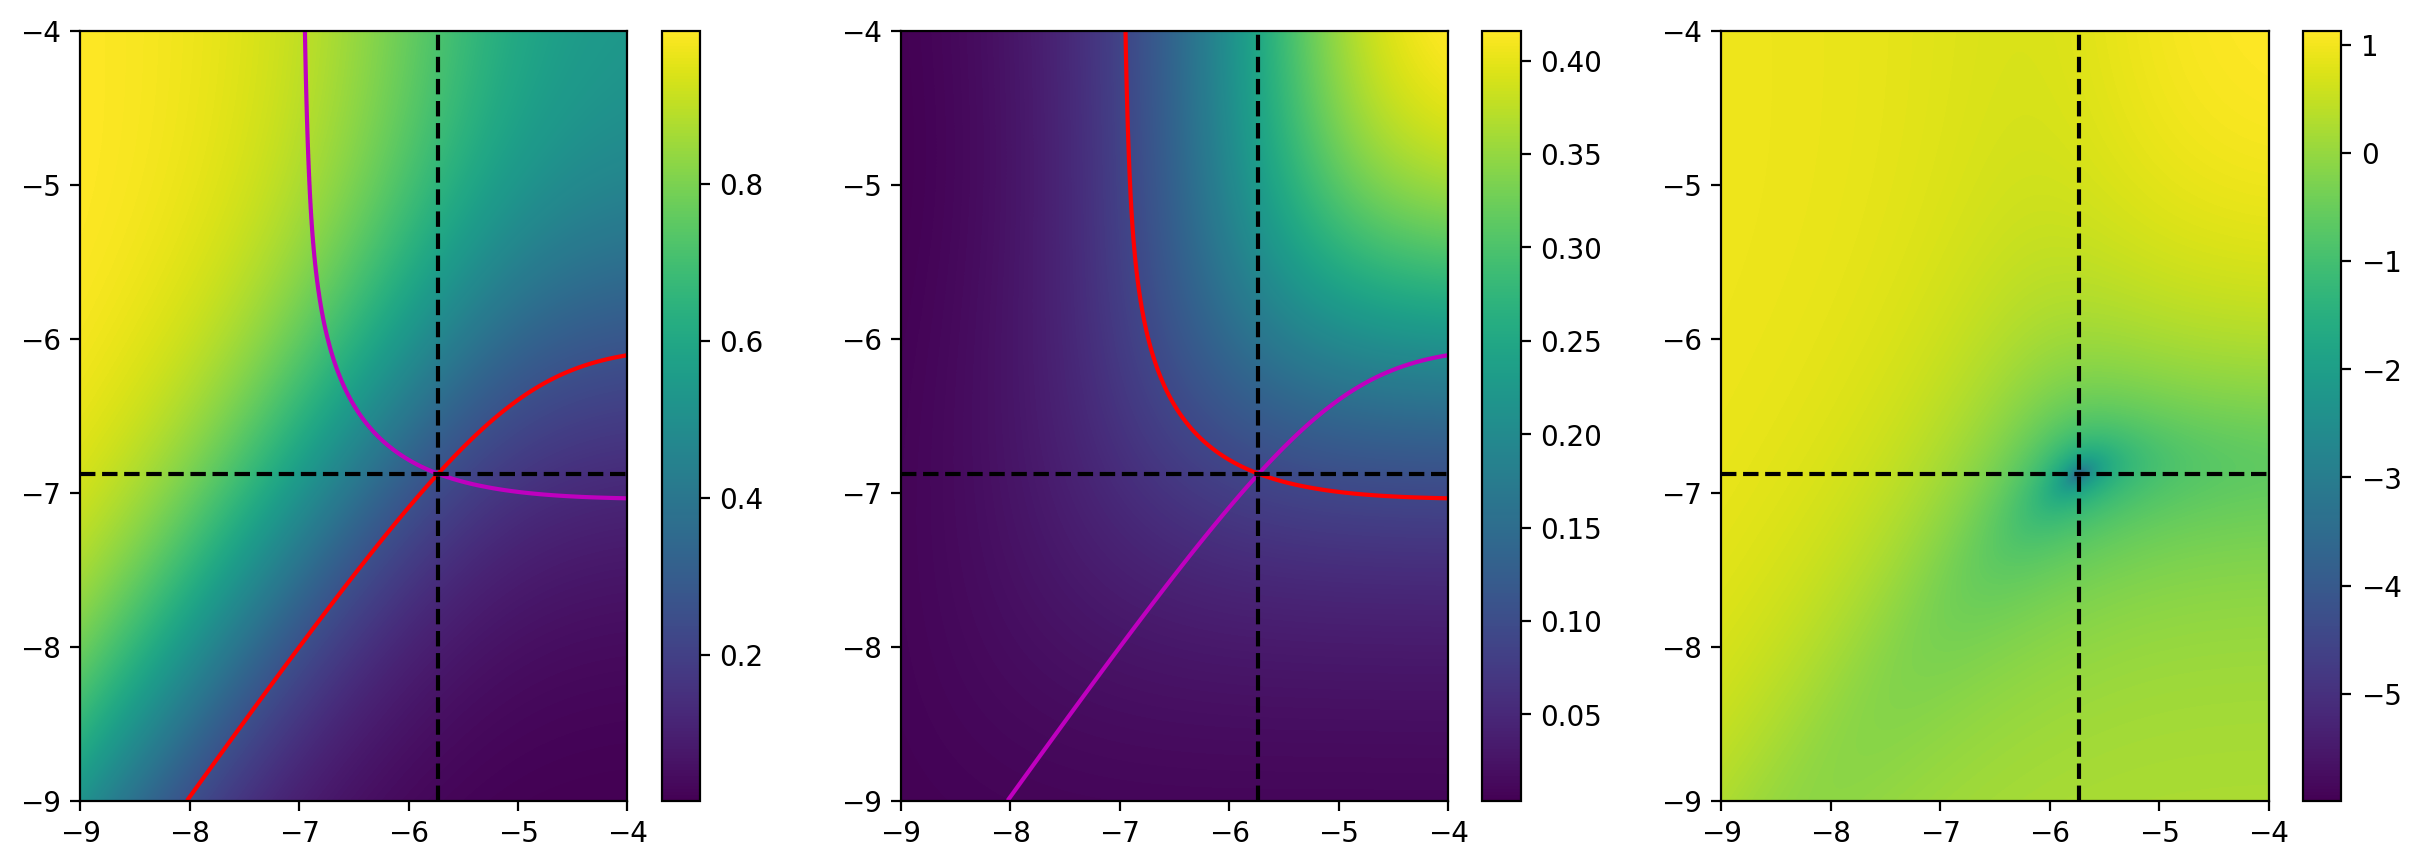

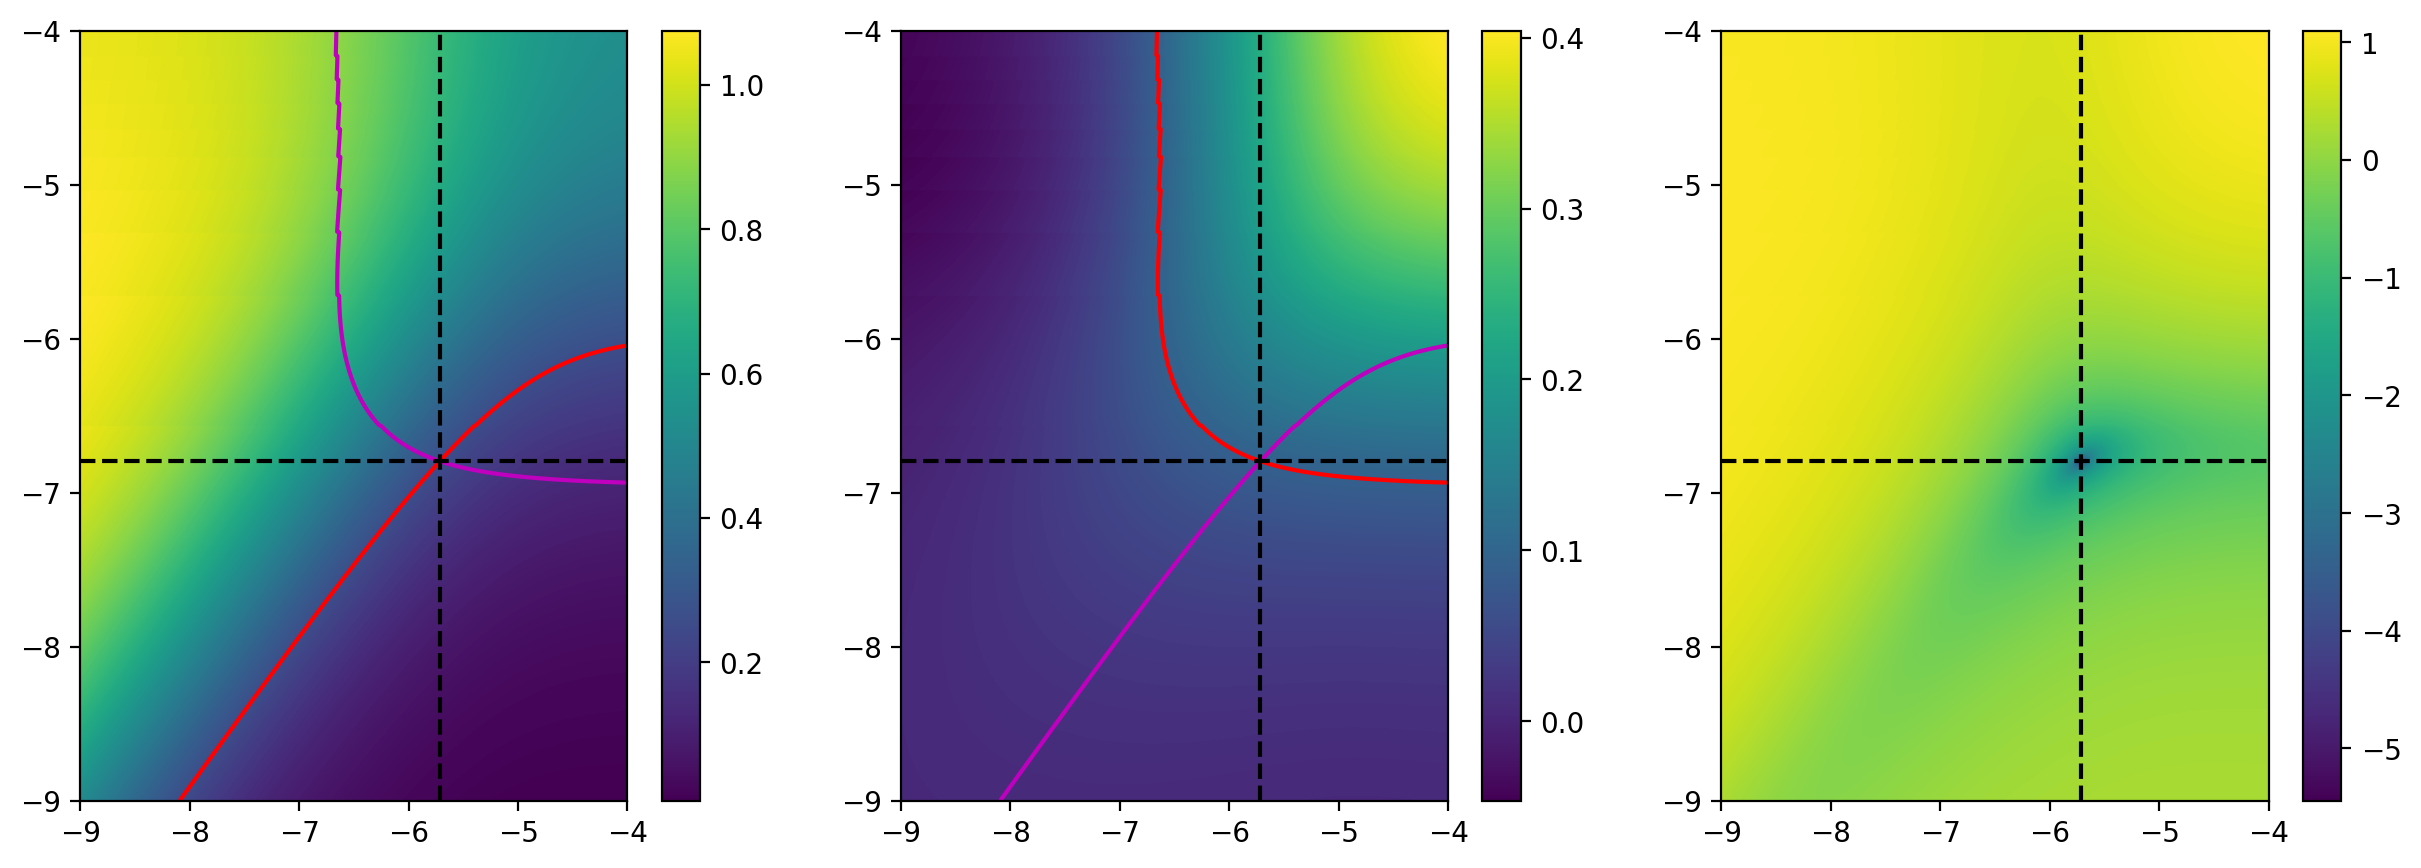

In [114]:
lPro = np.linspace(-9,-4,1000)
lTrp = np.linspace(-9,-4,1000)

def_com = community()

xmat, ymat = np.meshgrid(lPro, lTrp)

eq_data = df.loc[df['Condition']=='A']['Ratio'].mean() 
growth_data = df.loc[df['Condition']=='A']['Width'].mean() / df.loc[df['Condition']=='WT']['Width'].mean() 

community_A2 = community(lPro=10**xmat, lTrp=10**ymat, mu_WT=growth_rates['WT'], mu_dT=growth_rates['dT'], mu_dP=growth_rates['dP'], rho=fit_pars_1['rho'])
community_A3 = community(lPro=10**xmat, lTrp=10**ymat, mu_WT=growth_rates['WT'], mu_dT=growth_rates['dT'], mu_dP=growth_rates['dP'])

xfit2, yfit2 = fit_2D(lPro, lTrp, community_A2.eq, community_A2.rel_growth_wt, eq_data, growth_data)
xfit3, yfit3 = fit_2D(lPro, lTrp, community_A3.eq, community_A3.rel_growth_wt, eq_data, growth_data)

lPro_fit2 = 10**xfit2
lTrp_fit2 = 10**yfit2

lPro_fit3 = 10**xfit3
lTrp_fit3 = 10**yfit3

print(f"w/ rho: Pro leakage = {lPro_fit2:.3g} (original = {def_com.lPro:.3g}), Trp leakage = {lTrp_fit2:.3g} (original = {def_com.lTrp:.3g})")
print(f"no rho: Pro leakage = {lPro_fit3:.3g} (original = {def_com.lPro:.3g}), Trp leakage = {lTrp_fit3:.3g} (original = {def_com.lTrp:.3g})")
report_data(df, 'A')

fit_pars_0['lPro'] = def_com.lPro
fit_pars_1['lPro'] = def_com.lPro
fit_pars_2['lPro'] = lPro_fit2
fit_pars_3['lPro'] = lPro_fit3

fit_pars_0['lTrp'] = def_com.lTrp
fit_pars_1['lTrp'] = def_com.lTrp
fit_pars_2['lTrp'] = lTrp_fit2
fit_pars_3['lTrp'] = lTrp_fit3

---
### Characterize putP using community B

### fit change in sector size for dP relatitive to community A

c_up_P = 7.81 (no fit) || 7.81 (rho fit) || 4.65 (rho + leakage fit) || 4.65 (leakage fit)
eqFr-B = 0.42 (no fit) || 0.42 (rho fit) || 0.31 (rho + leakage fit) || 0.31 (leakage fit)
sec_dP = 7.39 (no fit) || 24.73 (rho fit) || 20.68 (rho + leakage fit) || 6.21 (leakage fit)
sec_PT = 2.89 (no fit) || 2.89 (rho fit) || 2.50 (rho + leakage fit) || 2.50 (leakage fit)
eqFr-A = 0.26 (no fit) || 0.28 (rho fit) || 0.26 (rho + leakage fit) || 0.26 (leakage fit)
Ex. CB: f(dT) = 0.42, rel. growth = 0.15, sectors dP = 22.54um, sectors dT = 34.60um, sector ratio = 0.94


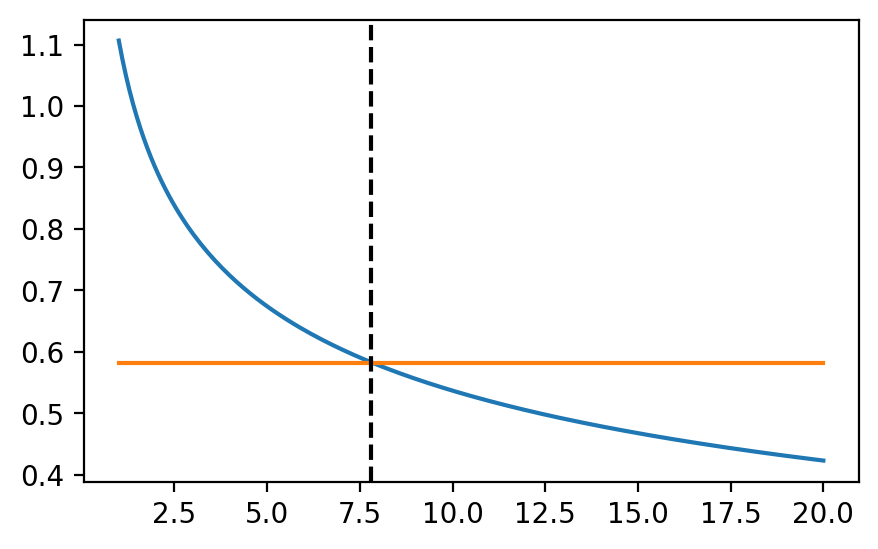

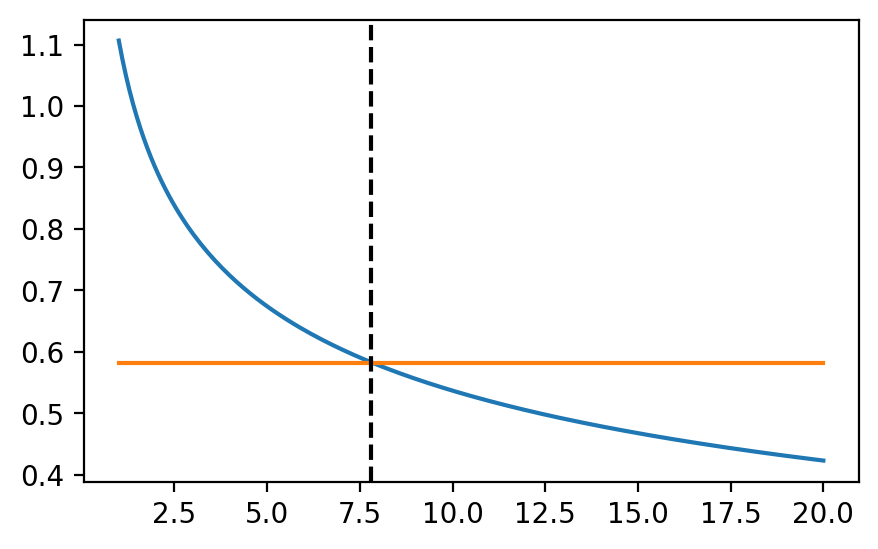

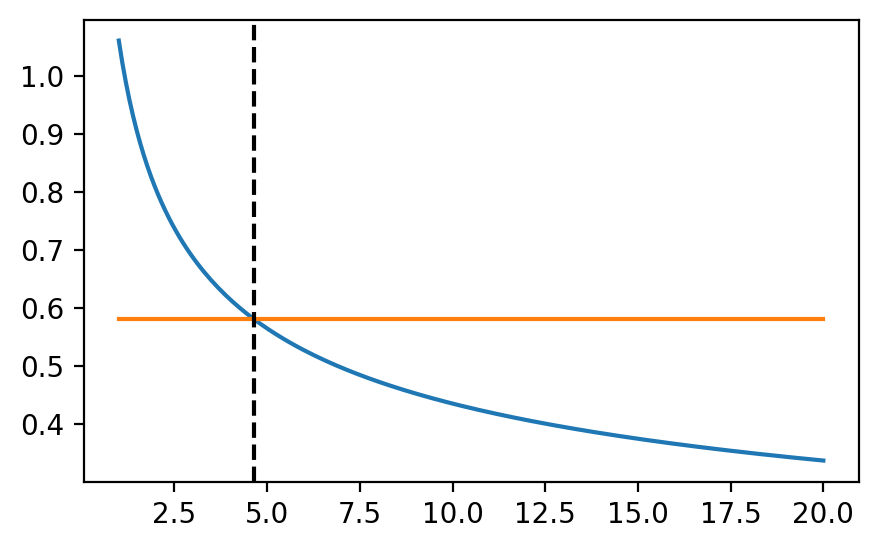

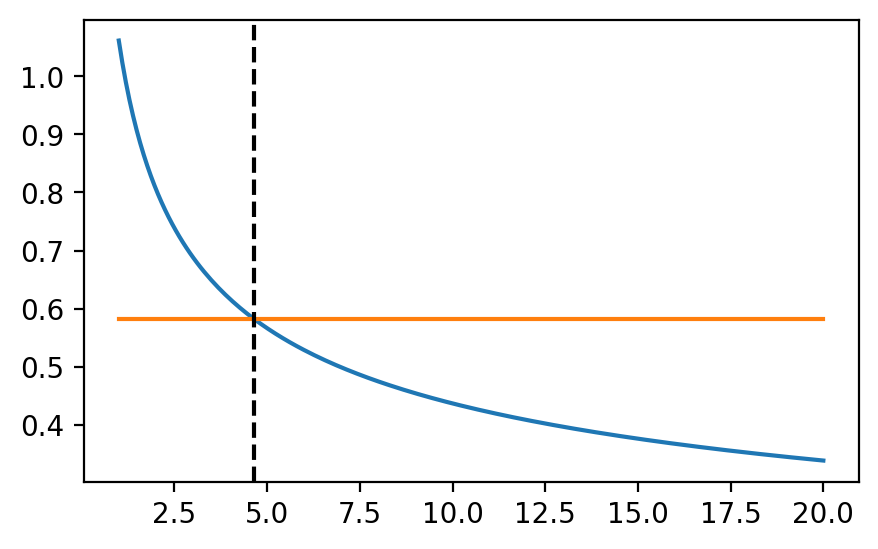

In [116]:
eq_data = df.loc[df['Condition']=='B']['Ratio'].values 
rel_dP_patch_data = df.loc[df['Condition']=='B']['dP_patch'].mean() / df.loc[df['Condition']=='A']['dP_patch'].mean()

c_up_P = np.linspace(1,20,199)
#option 0: no other fits
community_A0 = community(mu_WT=growth_rates['WT'], mu_dT=growth_rates['dT'], mu_dP=growth_rates['dP'])
community_B0 = community(mu_WT=growth_rates['WT'], mu_dT=growth_rates['dT'], mu_dP=growth_rates['dP_proUp'],c_up_P=c_up_P)
#option 1: fit rho
community_A1 = community(rho=fit_pars_1['rho'], mu_WT=growth_rates['WT'], mu_dT=growth_rates['dT'], mu_dP=growth_rates['dP'])
community_B1 = community(rho=fit_pars_1['rho'], mu_WT=growth_rates['WT'], mu_dT=growth_rates['dT'], mu_dP=growth_rates['dP_proUp'],c_up_P=c_up_P)
#option 2: fit rho and leakage
community_A2 = community(rho=fit_pars_2['rho'], lPro=fit_pars_2['lPro'], lTrp=fit_pars_2['lTrp'], mu_WT=growth_rates['WT'], mu_dT=growth_rates['dT'], mu_dP=growth_rates['dP'])
community_B2 = community(rho=fit_pars_2['rho'], lPro=fit_pars_2['lPro'], lTrp=fit_pars_2['lTrp'], mu_WT=growth_rates['WT'], mu_dT=growth_rates['dT'], mu_dP=growth_rates['dP_proUp'],c_up_P=c_up_P)
#option 3: fit leakage
community_A3 = community(lPro=fit_pars_3['lPro'], lTrp=fit_pars_3['lTrp'], mu_WT=growth_rates['WT'], mu_dT=growth_rates['dT'], mu_dP=growth_rates['dP'])
community_B3 = community(lPro=fit_pars_3['lPro'], lTrp=fit_pars_3['lTrp'], mu_WT=growth_rates['WT'], mu_dT=growth_rates['dT'], mu_dP=growth_rates['dP_proUp'],c_up_P=c_up_P)

y0 = community_B0.rangeP / community_A0.rangeP
y1 = community_B1.rangeP / community_A1.rangeP
y2 = community_B2.rangeP / community_A2.rangeP
y3 = community_B3.rangeP / community_A3.rangeP

c_up0, idx0 = fit_1D(c_up_P, rel_dP_patch_data, y0)
c_up1, idx1 = fit_1D(c_up_P, rel_dP_patch_data, y1)
c_up2, idx2 = fit_1D(c_up_P, rel_dP_patch_data, y2)
c_up3, idx3 = fit_1D(c_up_P, rel_dP_patch_data, y3)

print(f"c_up_P = {c_up0:.2f} (no fit) || {c_up1:.2f} (rho fit) || {c_up2:.2f} (rho + leakage fit) || {c_up3:.2f} (leakage fit)")
print(f"eqFr-B = {community_B0.eq[idx0]:.2f} (no fit) || {community_B1.eq[idx1]:.2f} (rho fit) || {community_B2.eq[idx2]:.2f} (rho + leakage fit) || {community_B3.eq[idx3]:.2f} (leakage fit)")
print(f"sec_dP = {community_B0.rangeP[idx0]:.2f} (no fit) || {community_B1.rangeP[idx1]:.2f} (rho fit) || {community_B2.rangeP[idx2]:.2f} (rho + leakage fit) || {community_B3.rangeP[idx3]:.2f} (leakage fit)")
print(f"sec_PT = {community_B0.rangeP[idx0]/community_B0.rangeT:.2f} (no fit) || {community_B1.rangeP[idx1]/community_B1.rangeT:.2f} (rho fit) || {community_B2.rangeP[idx2]/community_B2.rangeT:.2f} (rho + leakage fit) || {community_B3.rangeP[idx3]/community_B3.rangeT:.2f} (leakage fit)")
print(f"eqFr-A = {community_A0.eq:.2f} (no fit) || {community_A1.eq:.2f} (rho fit) || {community_A2.eq:.2f} (rho + leakage fit) || {community_A3.eq:.2f} (leakage fit)")

report_data(df, 'B')

fit_pars_0['c_up_P'] = c_up0 
fit_pars_1['c_up_P'] = c_up1 
fit_pars_2['c_up_P'] = c_up2 
fit_pars_3['c_up_P'] = c_up3 


#### Fit to ratio in dP to dT patch size (this seems problametic as it is highly variable)

c_up_P = 173.87 (no fit) || 173.87 (rho fit) || 65.32 (rho + leakage fit) || 66.33 (leakage fit)
eqFrac = 0.40 (no fit) || 0.42 (rho fit) || 0.26 (rho + leakage fit) || 0.23 (leakage fit)
sec_dP = 2.40 (no fit) || 8.04 (rho fit) || 7.78 (rho + leakage fit) || 2.33 (leakage fit)
sec_PT = 0.94 (no fit) || 0.94 (rho fit) || 0.94 (rho + leakage fit) || 0.94 (leakage fit)
Ex. CB: f(dT) = 0.42, rel. growth = 0.15, sectors dP = 22.54um, sectors dT = 34.60um, sector ratio = 0.94


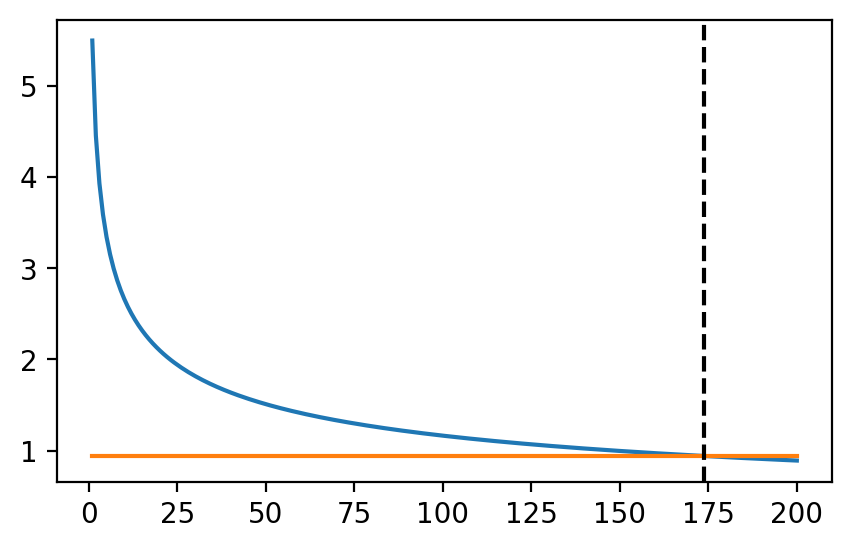

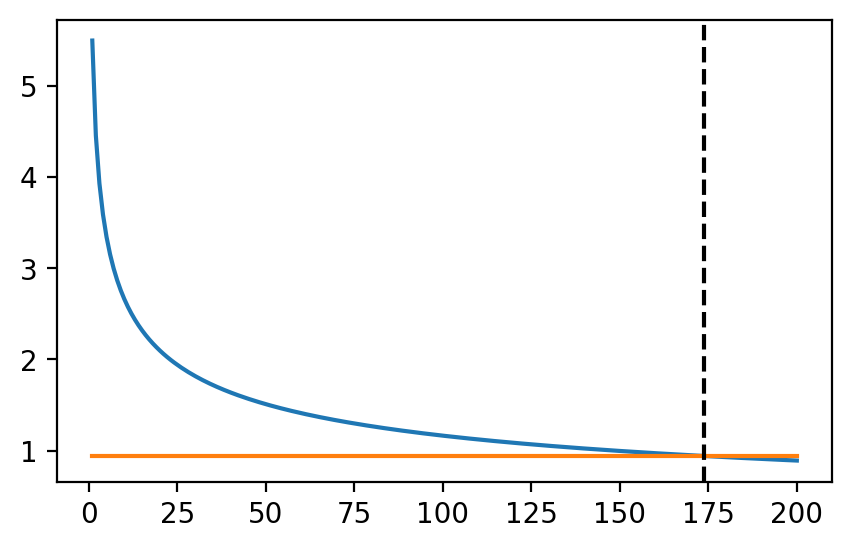

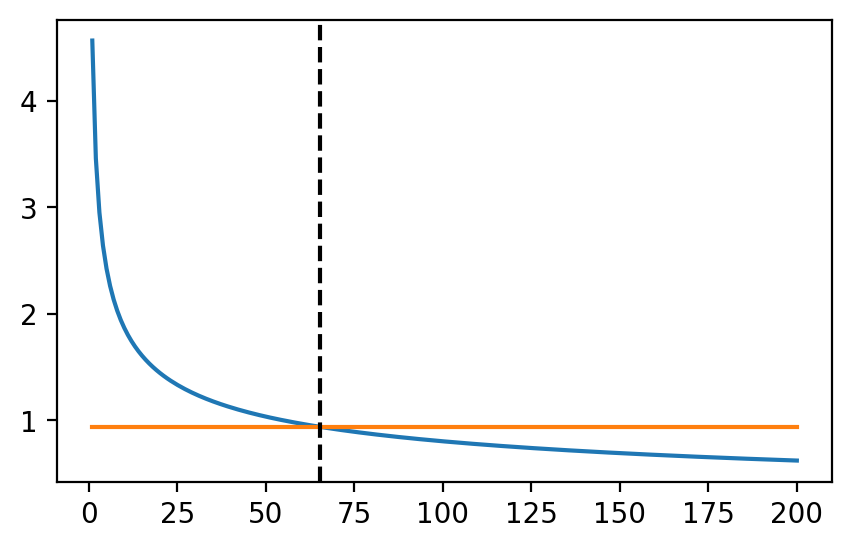

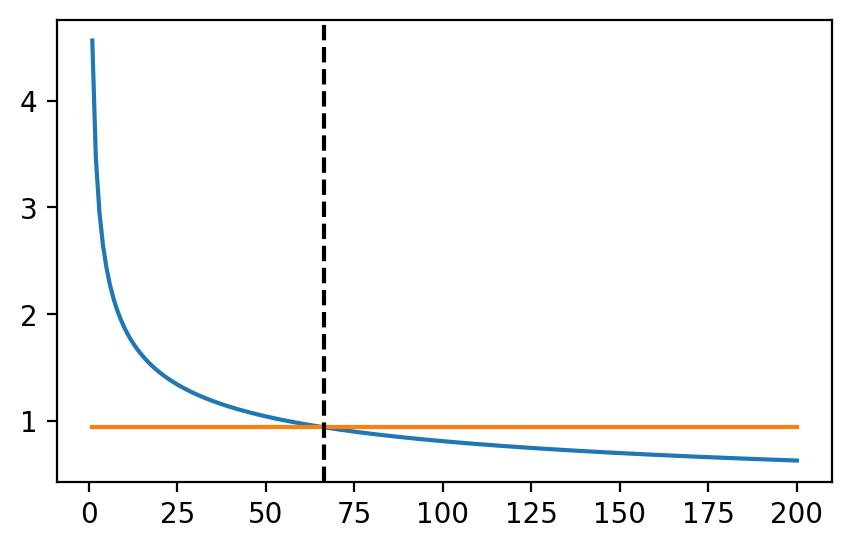

In [117]:
rel_dP_dT_patch_data = df.loc[df['Condition']=='B']['rel_range'].mean() 

c_up_P = np.linspace(1,200,199)
#option 0: no other fits
community_B0 = community(mu_WT=growth_rates['WT'], mu_dT=growth_rates['dT'], mu_dP=growth_rates['dP_proUp'],c_up_P=c_up_P)
#option 1: fit rho
community_B1 = community(rho=fit_pars_1['rho'], mu_WT=growth_rates['WT'], mu_dT=growth_rates['dT'], mu_dP=growth_rates['dP_proUp'],c_up_P=c_up_P)
#option 2: fit rho and leakage
community_B2 = community(rho=fit_pars_2['rho'], lPro=fit_pars_2['lPro'], lTrp=fit_pars_2['lTrp'], mu_WT=growth_rates['WT'], mu_dT=growth_rates['dT'], mu_dP=growth_rates['dP_proUp'],c_up_P=c_up_P)
#option 3: fit leakage
community_B3 = community(lPro=fit_pars_3['lPro'], lTrp=fit_pars_3['lTrp'], mu_WT=growth_rates['WT'], mu_dT=growth_rates['dT'], mu_dP=growth_rates['dP_proUp'],c_up_P=c_up_P)

y0 = community_B0.rangeP / community_B0.rangeT
y1 = community_B1.rangeP / community_B1.rangeT
y2 = community_B2.rangeP / community_B2.rangeT
y3 = community_B3.rangeP / community_B3.rangeT

c_up0, idx0 = fit_1D(c_up_P, rel_dP_dT_patch_data, y0)
c_up1, idx1 = fit_1D(c_up_P, rel_dP_dT_patch_data, y1)
c_up2, idx2 = fit_1D(c_up_P, rel_dP_dT_patch_data, y2)
c_up3, idx3 = fit_1D(c_up_P, rel_dP_dT_patch_data, y3)

print(f"c_up_P = {c_up0:.2f} (no fit) || {c_up1:.2f} (rho fit) || {c_up2:.2f} (rho + leakage fit) || {c_up3:.2f} (leakage fit)")
print(f"eqFrac = {community_B0.eq[idx0]:.2f} (no fit) || {community_B1.eq[idx1]:.2f} (rho fit) || {community_B2.eq[idx2]:.2f} (rho + leakage fit) || {community_B3.eq[idx3]:.2f} (leakage fit)")
print(f"sec_dP = {community_B0.rangeP[idx0]:.2f} (no fit) || {community_B1.rangeP[idx1]:.2f} (rho fit) || {community_B2.rangeP[idx2]:.2f} (rho + leakage fit) || {community_B3.rangeP[idx3]:.2f} (leakage fit)")
print(f"sec_PT = {community_B0.rangeP[idx0]/community_B0.rangeT:.2f} (no fit) || {community_B1.rangeP[idx1]/community_B1.rangeT:.2f} (rho fit) || {community_B2.rangeP[idx2]/community_B2.rangeT:.2f} (rho + leakage fit) || {community_B3.rangeP[idx3]/community_B3.rangeT:.2f} (leakage fit)")

report_data(df, 'B')


----

### Characterize trpR using community C


Fit trpR  increase in trp release for community C based on EQ data

c_prod_T_P = 220.00 (no fit) || 304.00 (rho fit) || 32.00 (rho + leakage fit) || 25.00 (leakage fit)
eqFrac = 0.59 (no fit) || 0.59 (rho fit) || 0.59 (rho + leakage fit) || 0.59 (leakage fit)
relmu = 0.38 (no fit) || 0.39 (rho fit) || 0.21 (rho + leakage fit) || 0.20 (leakage fit)
Ex. CC: f(dT) = 0.59, rel. growth = -0.00, sectors dP = 19.25um, sectors dT = 8.28um, sector ratio = 2.40


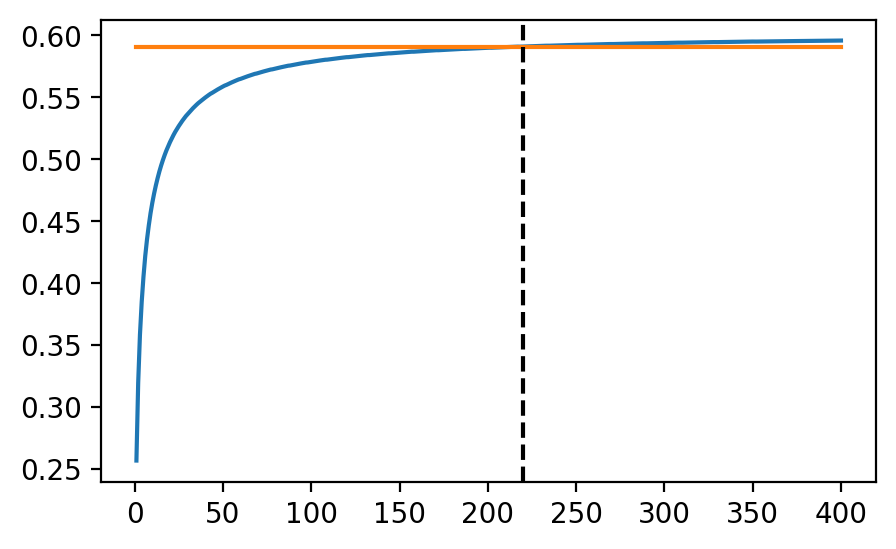

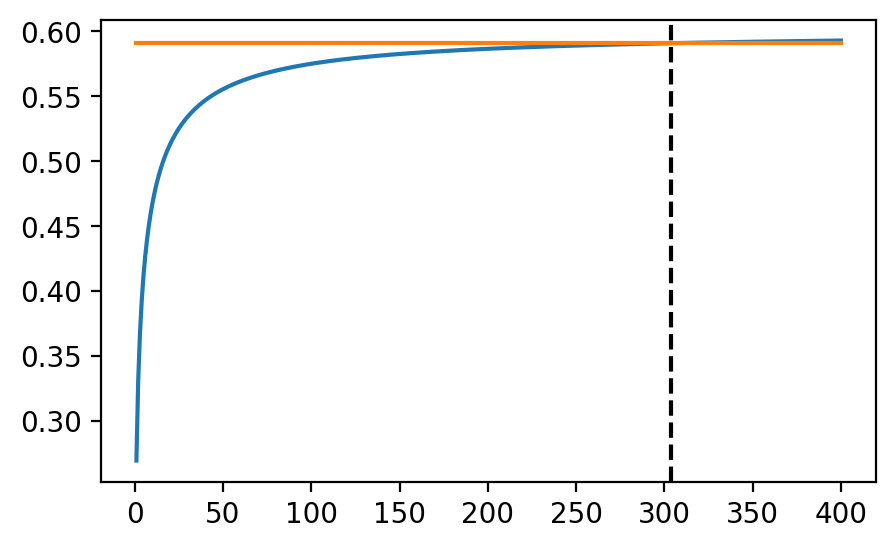

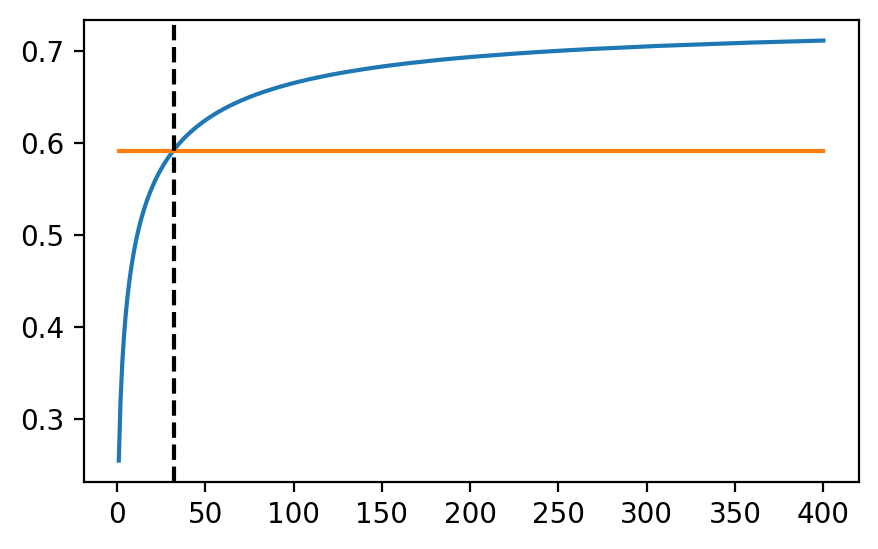

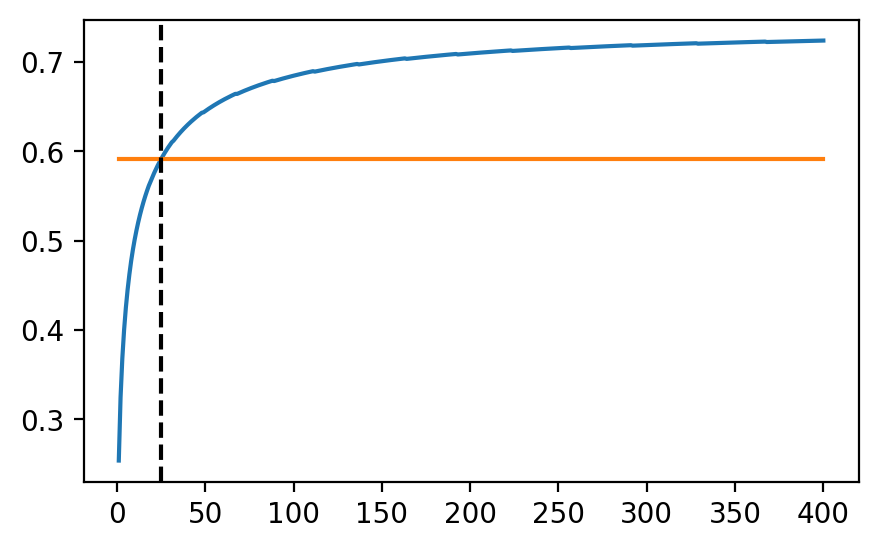

In [118]:
#get measured value
eq_data = df.loc[df['Condition']=='C']['Ratio'].mean() 

#calc model predictions with varying cost for putP
c_prod_T = np.linspace(1,400,400)

#option 0: no other fits
community_C0 = community(mu_WT=growth_rates['WT'], mu_dT=growth_rates['dT'], mu_dP=growth_rates['dP_trpOP'],c_prod_T=c_prod_T)
#option 1: fit rho
community_C1 = community(rho=fit_pars_1['rho'], mu_WT=growth_rates['WT'], mu_dT=growth_rates['dT'], mu_dP=growth_rates['dP_trpOP'],c_prod_T=c_prod_T)
#option 2: fit rho and leakage
community_C2 = community(rho=fit_pars_2['rho'], lPro=fit_pars_2['lPro'], lTrp=fit_pars_2['lTrp'], mu_WT=growth_rates['WT'], mu_dT=growth_rates['dT'], mu_dP=growth_rates['dP_trpOP'],c_prod_T=c_prod_T)
#option 3: fit leakage
community_C3 = community(lPro=fit_pars_3['lPro'], lTrp=fit_pars_3['lTrp'], mu_WT=growth_rates['WT'], mu_dT=growth_rates['dT'], mu_dP=growth_rates['dP_trpOP'],c_prod_T=c_prod_T)

y0 = community_C0.eq
y1 = community_C1.eq
y2 = community_C2.eq
y3 = community_C3.eq

c_prod_T0, idx0 = fit_1D(c_prod_T, eq_data, y0)
c_prod_T1, idx1 = fit_1D(c_prod_T, eq_data, y1)
c_prod_T2, idx2 = fit_1D(c_prod_T, eq_data, y2)
c_prod_T3, idx3 = fit_1D(c_prod_T, eq_data, y3)

print(f"c_prod_T_P = {c_prod_T0:.2f} (no fit) || {c_prod_T1:.2f} (rho fit) || {c_prod_T2:.2f} (rho + leakage fit) || {c_prod_T3:.2f} (leakage fit)")
print(f"eqFrac = {community_C0.eq[idx0]:.2f} (no fit) || {community_C1.eq[idx1]:.2f} (rho fit) || {community_C2.eq[idx2]:.2f} (rho + leakage fit) || {community_C3.eq[idx3]:.2f} (leakage fit)")
print(f"relmu = {community_C0.rel_growth_wt[idx0]:.2f} (no fit) || {community_C1.rel_growth_wt[idx1]:.2f} (rho fit) || {community_C2.rel_growth_wt[idx2]:.2f} (rho + leakage fit) || {community_C3.rel_growth_wt[idx3]:.2f} (leakage fit)")

report_data(df, 'C')

fit_pars_0['c_prod_T'] = c_prod_T0 
fit_pars_1['c_prod_T'] = c_prod_T1 
fit_pars_2['c_prod_T'] = c_prod_T2 
fit_pars_3['c_prod_T'] = c_prod_T3 

----

### Characterize proB74 using community E

Fit proB74 increase in pro release for community E based on EQ data


c_prod_P = 39.94 (no fit) || 50.00 (rho fit) || 2.18 (rho + leakage fit) || 2.08 (leakage fit)
eqFrac = 0.19 (no fit) || 0.20 (rho fit) || 0.19 (rho + leakage fit) || 0.19 (leakage fit)
relmu = 0.16 (no fit) || 0.17 (rho fit) || 0.09 (rho + leakage fit) || 0.09 (leakage fit)
Ex. CE: f(dT) = 0.19, rel. growth = 0.74, sectors dP = 491.05um, sectors dT = 119.57um, sector ratio = 4.07


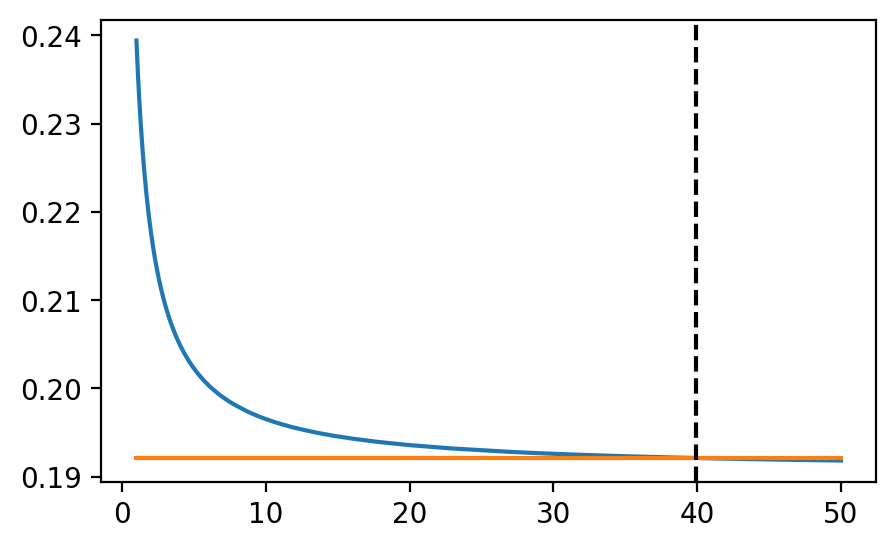

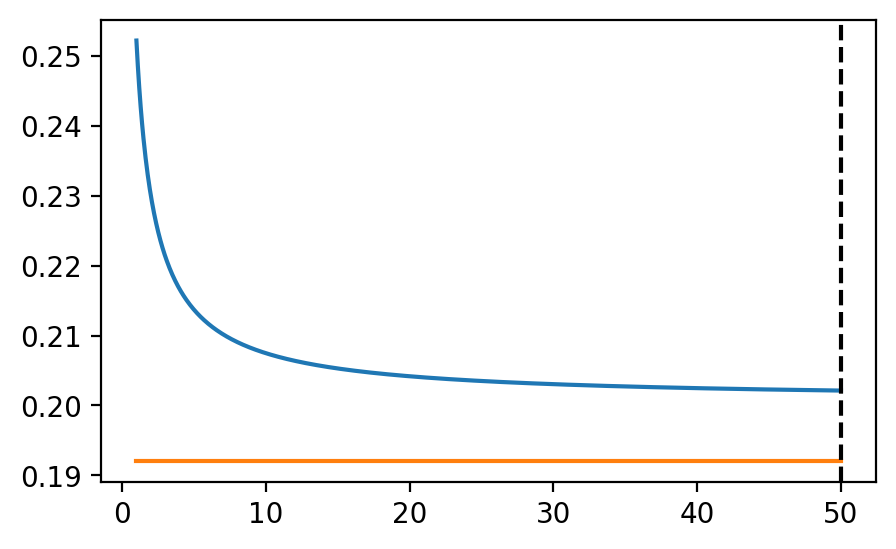

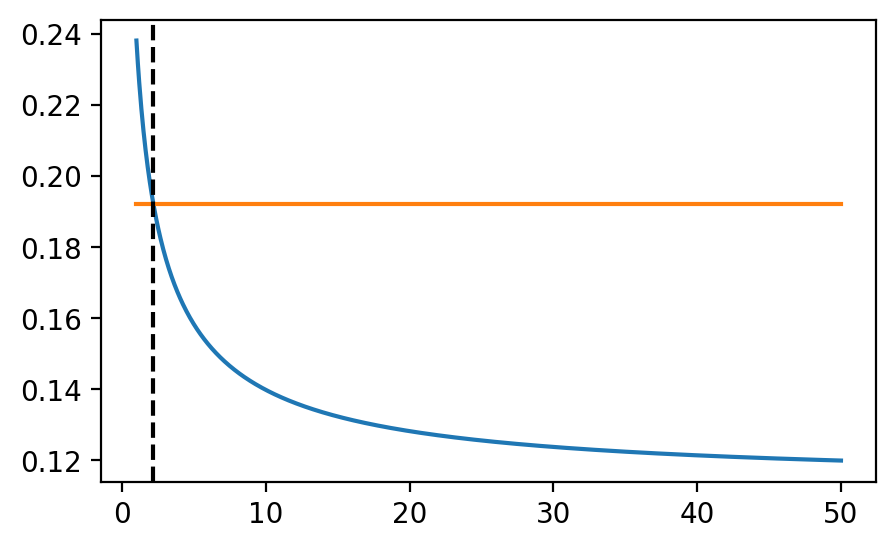

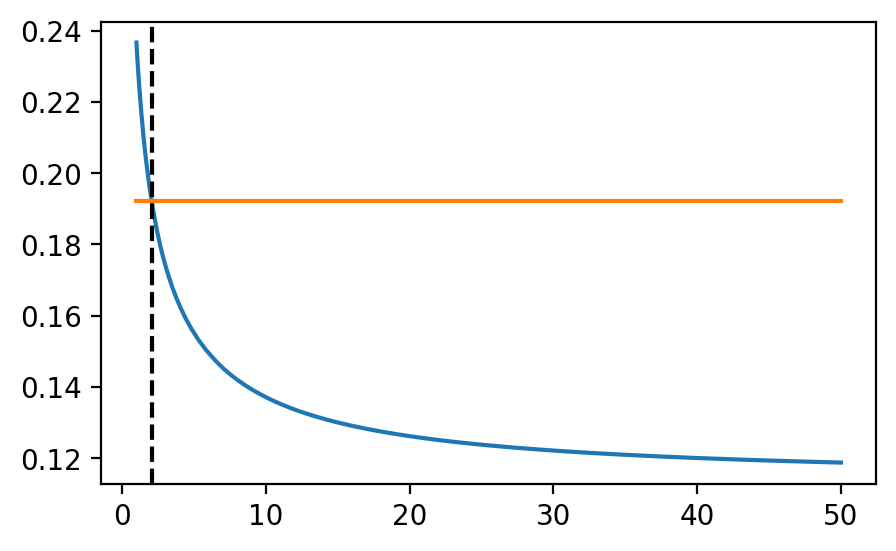

In [124]:
#get measured value
eq_data = df.loc[df['Condition']=='E']['Ratio'].mean() 

#calc model predictions with varying cost for putP
c_prod_P = np.linspace(1,50,1000)

#option 0: no other fits
community_E0 = community(mu_WT=growth_rates['WT'], mu_dT=growth_rates['dT_proOP'], mu_dP=growth_rates['dP'],c_prod_P=c_prod_P)
#option 1: fit rho
community_E1 = community(rho=fit_pars_1['rho'], mu_WT=growth_rates['WT'], mu_dT=growth_rates['dT_proOP'], mu_dP=growth_rates['dP'],c_prod_P=c_prod_P)
#option 2: fit rho and leakage
community_E2 = community(rho=fit_pars_2['rho'], lPro=fit_pars_2['lPro'], lTrp=fit_pars_2['lTrp'], mu_WT=growth_rates['WT'], mu_dT=growth_rates['dT_proOP'], mu_dP=growth_rates['dP'],c_prod_P=c_prod_P)
#option 3: fit leakage
community_E3 = community(lPro=fit_pars_3['lPro'], lTrp=fit_pars_3['lTrp'], mu_WT=growth_rates['WT'], mu_dT=growth_rates['dT_proOP'], mu_dP=growth_rates['dP'],c_prod_P=c_prod_P)

y0 = community_E0.eq
y1 = community_E1.eq
y2 = community_E2.eq
y3 = community_E3.eq

c_prod_P0, idx0 = fit_1D(c_prod_P, eq_data, y0)
c_prod_P1, idx1 = fit_1D(c_prod_P, eq_data, y1)
c_prod_P2, idx2 = fit_1D(c_prod_P, eq_data, y2)
c_prod_P3, idx3 = fit_1D(c_prod_P, eq_data, y3)

print(f"c_prod_P = {c_prod_P0:.2f} (no fit) || {c_prod_P1:.2f} (rho fit) || {c_prod_P2:.2f} (rho + leakage fit) || {c_prod_P3:.2f} (leakage fit)")
print(f"eqFrac = {community_E0.eq[idx0]:.2f} (no fit) || {community_E1.eq[idx1]:.2f} (rho fit) || {community_E2.eq[idx2]:.2f} (rho + leakage fit) || {community_E3.eq[idx3]:.2f} (leakage fit)")
print(f"relmu = {community_E0.rel_growth_wt[idx0]:.2f} (no fit) || {community_E1.rel_growth_wt[idx1]:.2f} (rho fit) || {community_E2.rel_growth_wt[idx2]:.2f} (rho + leakage fit) || {community_E3.rel_growth_wt[idx3]:.2f} (leakage fit)")

report_data(df, 'E')

fit_pars_0['c_prod_P'] = c_prod_P0 
fit_pars_1['c_prod_P'] = c_prod_P1 
fit_pars_2['c_prod_P'] = c_prod_P2 
fit_pars_3['c_prod_P'] = c_prod_P3 

---

## Report fitting results

In [136]:
fit_pars_0

{'rho': 0.65,
 'lPro': 1.59e-05,
 'lTrp': 6.04e-07,
 'c_up_P': 7.813131313131312,
 'c_prod_T': 220.0,
 'c_prod_P': 39.94494494494494}

In [203]:
def predict_community_prop(fit_pars_loc): 
    par_com_A = {'rho': fit_pars_loc['rho'], 
                'lPro': fit_pars_loc['lPro'], 
                'lTrp': fit_pars_loc['lTrp'], 
                'c_prod_T': 1, 
                'c_prod_P': 1,
                'c_up_P': 1,
                'mu_dP': growth_rates['dP'],
                'mu_dT': growth_rates['dT'],
                }

    par_com_B = {'rho': fit_pars_loc['rho'], 
                'lPro': fit_pars_loc['lPro'], 
                'lTrp': fit_pars_loc['lTrp'], 
                'c_prod_T': 1, 
                'c_prod_P': 1,
                'c_up_P': fit_pars_loc['c_up_P'],
                'mu_dP': growth_rates['dP_proUp'],
                'mu_dT': growth_rates['dT'],
                }

    par_com_C = {'rho': fit_pars_loc['rho'], 
                'lPro': fit_pars_loc['lPro'], 
                'lTrp': fit_pars_loc['lTrp'], 
                'c_prod_T': fit_pars_loc['c_prod_T'], 
                'c_prod_P': 1,
                'c_up_P': 1,
                'mu_dP': growth_rates['dP_trpOP'],
                'mu_dT': growth_rates['dT'],
                }

    par_com_D = {'rho': fit_pars_loc['rho'], 
                'lPro': fit_pars_loc['lPro'], 
                'lTrp': fit_pars_loc['lTrp'], 
                'c_prod_T': fit_pars_loc['c_prod_T'], 
                'c_prod_P': 1,
                'c_up_P': fit_pars_loc['c_up_P'],
                'mu_dP': growth_rates['dP_proUp'], #need to be measured
                'mu_dT': growth_rates['dT'],
                }

    par_com_E = {'rho': fit_pars_loc['rho'], 
                'lPro': fit_pars_loc['lPro'], 
                'lTrp': fit_pars_loc['lTrp'], 
                'c_prod_T': 1, 
                'c_prod_P': fit_pars_loc['c_prod_P'],
                'c_up_P': 1,
                'mu_dP': growth_rates['dP'],
                'mu_dT': growth_rates['dT_proOP'],
                }

    par_com_F = {'rho': fit_pars_loc['rho'], 
                'lPro': fit_pars_loc['lPro'], 
                'lTrp': fit_pars_loc['lTrp'], 
                'c_prod_T': 1, 
                'c_prod_P': fit_pars_loc['c_prod_P'],
                'c_up_P': fit_pars_loc['c_up_P'],
                'mu_dP': growth_rates['dP_proUp'], 
                'mu_dT': growth_rates['dT_proOP'],
                }


    par_com_G = {'rho': fit_pars_loc['rho'], 
                'lPro': fit_pars_loc['lPro'], 
                'lTrp': fit_pars_loc['lTrp'], 
                'c_prod_T': fit_pars_loc['c_prod_T'], 
                'c_prod_P': fit_pars_loc['c_prod_P'],
                'c_up_P': 1,
                'mu_dP': growth_rates['dP_trpOP'],
                'mu_dT': growth_rates['dT_proOP'],
                }

    par_com_H = {'rho': fit_pars_loc['rho'], 
                'lPro': fit_pars_loc['lPro'], 
                'lTrp': fit_pars_loc['lTrp'], 
                'c_prod_T': fit_pars_loc['c_up_P'], 
                'c_prod_P': fit_pars_loc['c_prod_P'],
                'c_up_P': fit_pars_loc['c_up_P'],
                'mu_dP': growth_rates['dP_proUp'], #needs to be measured
                'mu_dT': growth_rates['dT_proOP'],
                }


    par_coms = {'A': par_com_A, 'B': par_com_B, 'C': par_com_C, 'D': par_com_D, 'E': par_com_E, 'F': par_com_F, 'G': par_com_G, 'H': par_com_H}    

    communities = {key: community(mu_WT=growth_rates['WT'], **val) for key, val in par_coms.items()}


    df_pred = pd.DataFrame()
    for key, val in communities.items():
        df_pred.loc[key, 'community'] = key
        df_pred.loc[key, 'source'] = 'prediction'
        df_pred.loc[key, 'eq freq'] = val.eq
        df_pred.loc[key, 'relative growth'] = val.rel_growth_wt
        df_pred.loc[key, 'relative range'] = val.rangeP/val.rangeT
        df_pred.loc[key, 'range dP'] = val.rangeP
        df_pred.loc[key, 'range dT'] = val.rangeT
        
    columns_data={'Condition': 'community', 'Ratio': 'eq freq', 'rel_growth': 'relative growth', 'rel_range': 'relative range', 'dT_patch': 'range dT', 'dP_patch': 'range dP'}
    df_data = df_mean.copy()
    df_data = df_data.rename(columns=columns_data)
    df_data['relative growth'] = df_data['Width'] / df_data.loc[df_data['community']=='WT']['Width'].values[0]
    df_data = df_data[df_data['community'] != 'WT'].reset_index(drop=True)
    df_data['source'] = 'data'
    df_data.drop('Width',axis=1,inplace=True)    

    return pd.concat([df_data, df_pred]).reset_index(drop=True)


In [232]:
fit_par_list = [fit_pars_0, fit_pars_1, fit_pars_2, fit_pars_3]
fit_par_name = ['no fitting on A','density fitting on A','density and leakage fitting on A','leakage fitting on A']
df_list = [predict_community_prop(fit_pars) for fit_pars in fit_par_list]

In [235]:
def plot_predictions(df, name):
    fig, axs = plt.subplots(3,2,figsize=(16,10))

    sns.barplot(df, x="community", y="eq freq", hue="source", ax=axs[0][0])
    sns.barplot(df, x="community", y="relative growth", hue="source", ax=axs[1][0])
    sns.barplot(df, x="community", y="relative range", hue="source", ax=axs[0][1])
    sns.barplot(df, x="community", y="range dT", hue="source", ax=axs[2][0])
    sns.barplot(df, x="community", y="range dP", hue="source", ax=axs[2][1])
    fig.tight_layout()

    #add text in axs[1][1]
    axs[1][1].text(0.5,0.5, f"{name:s}", color='k', fontsize=10)

    fig.savefig(f"{name:s}.pdf")
    
    return None

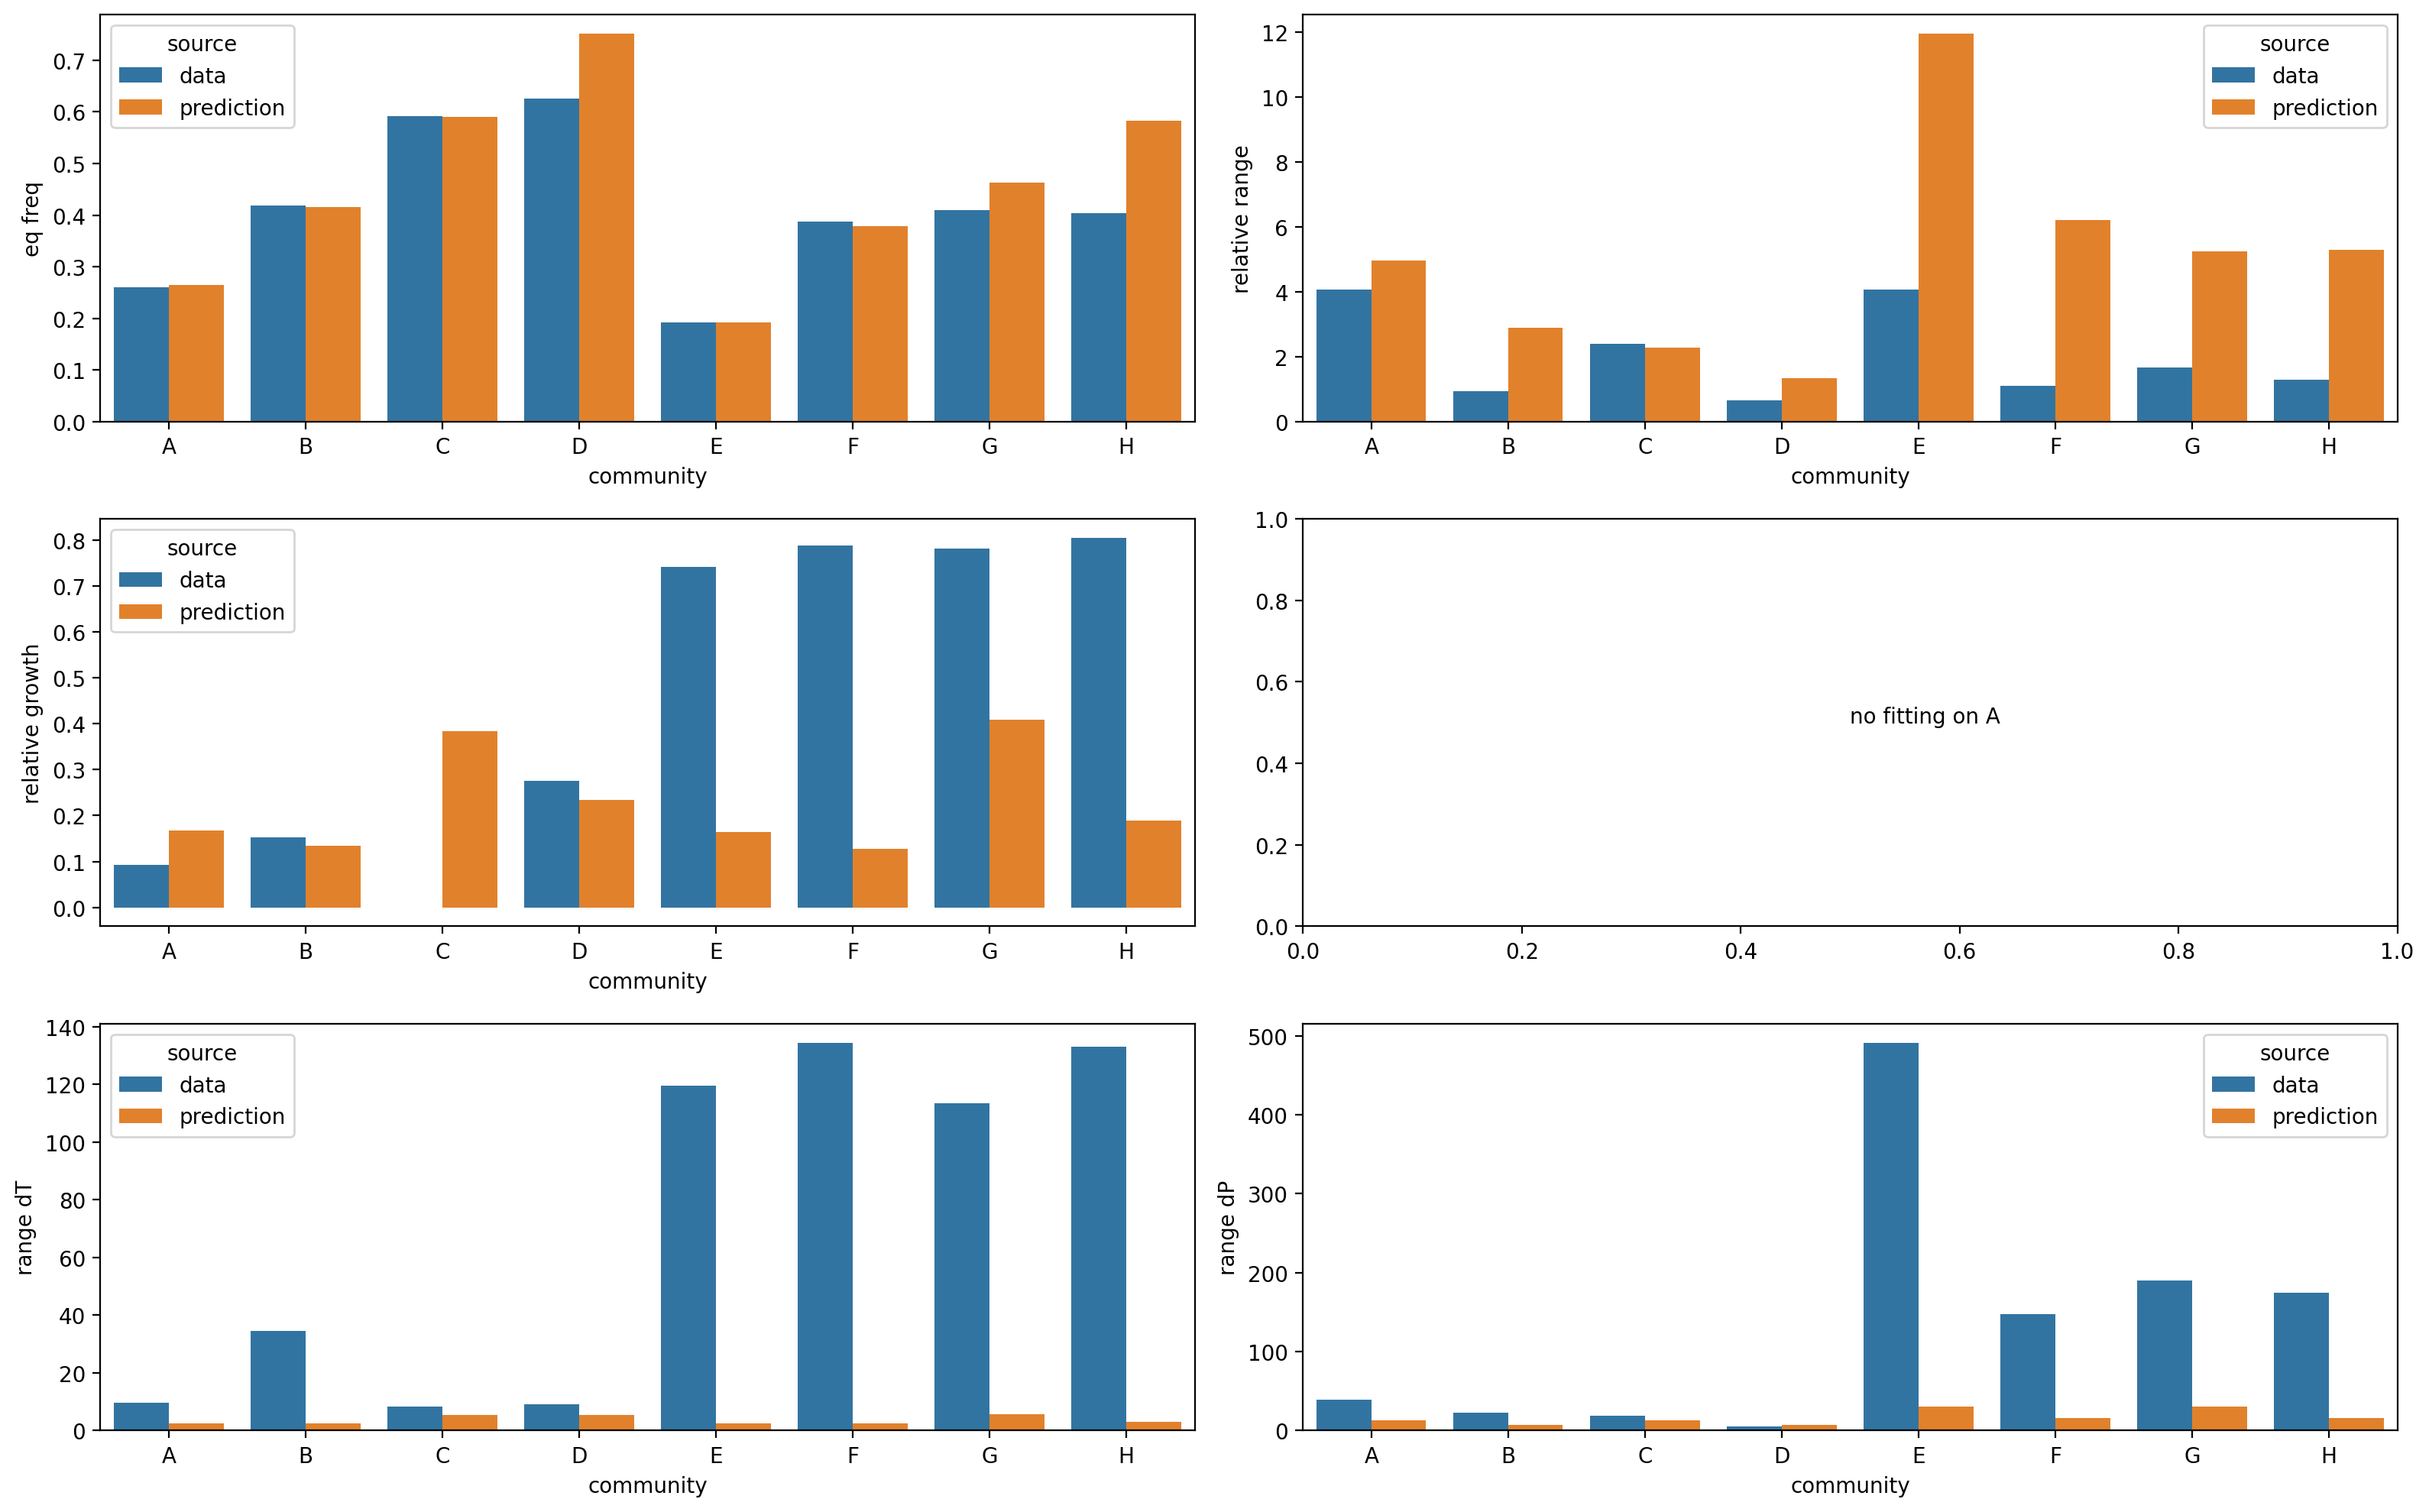

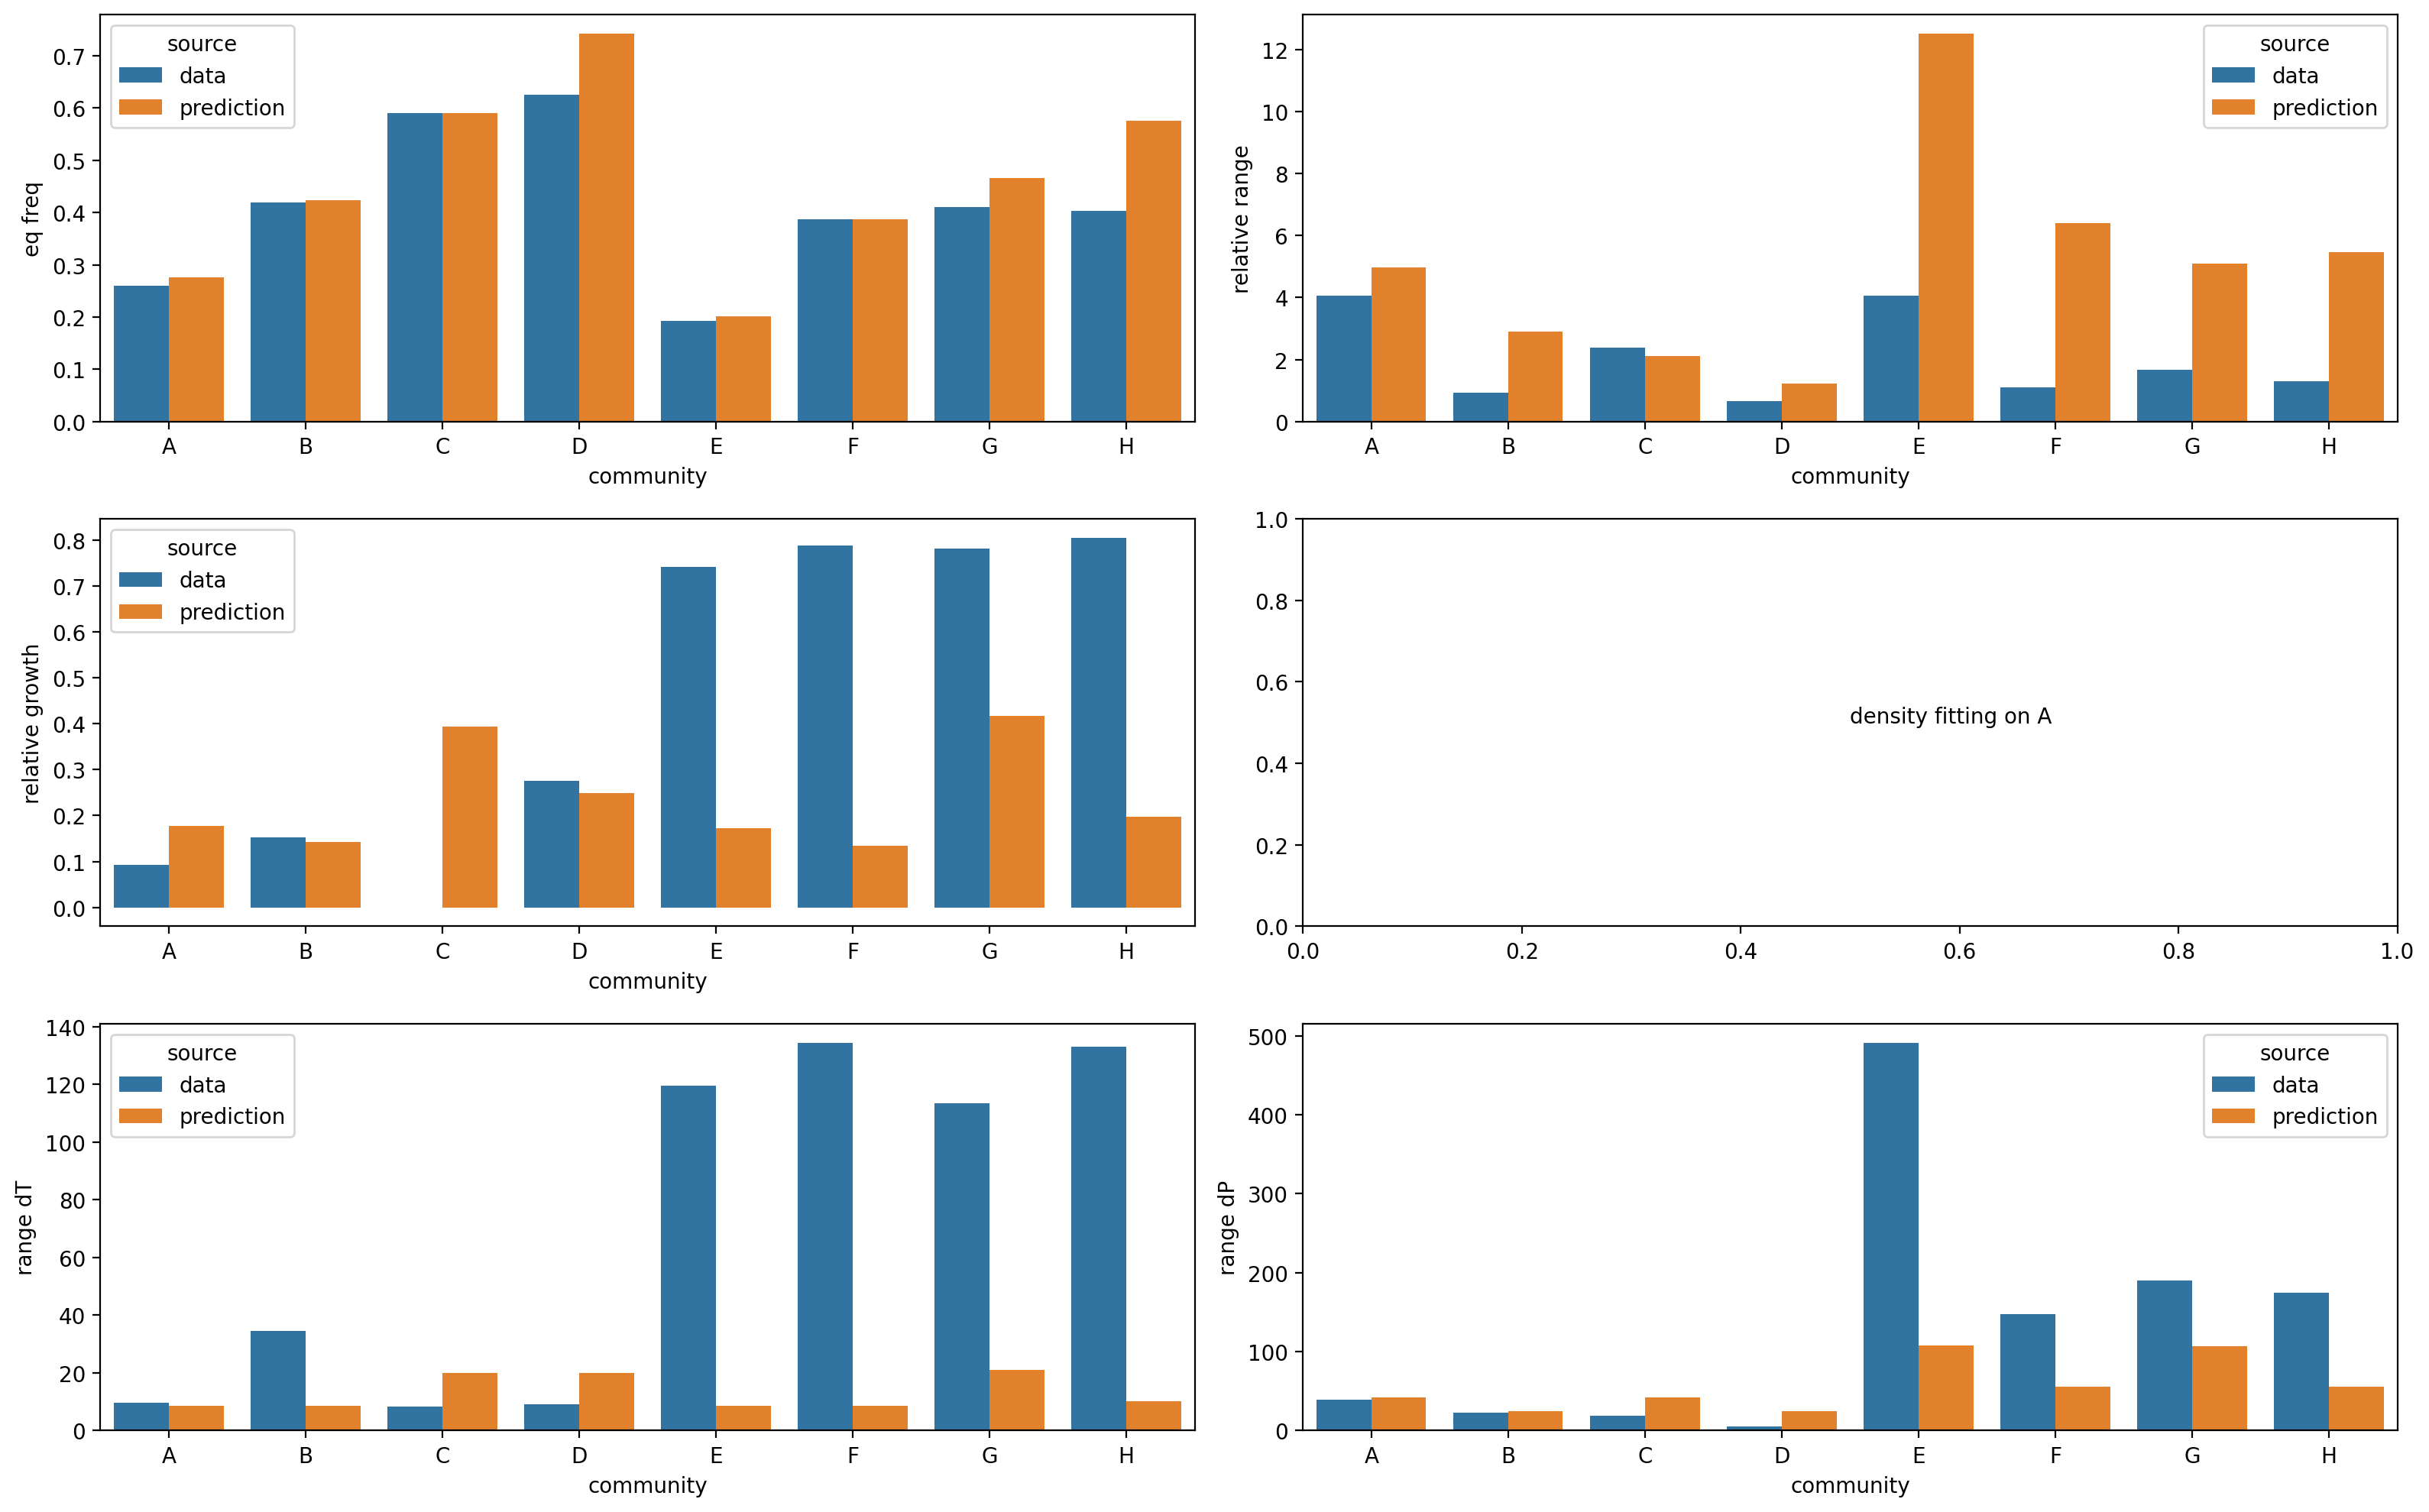

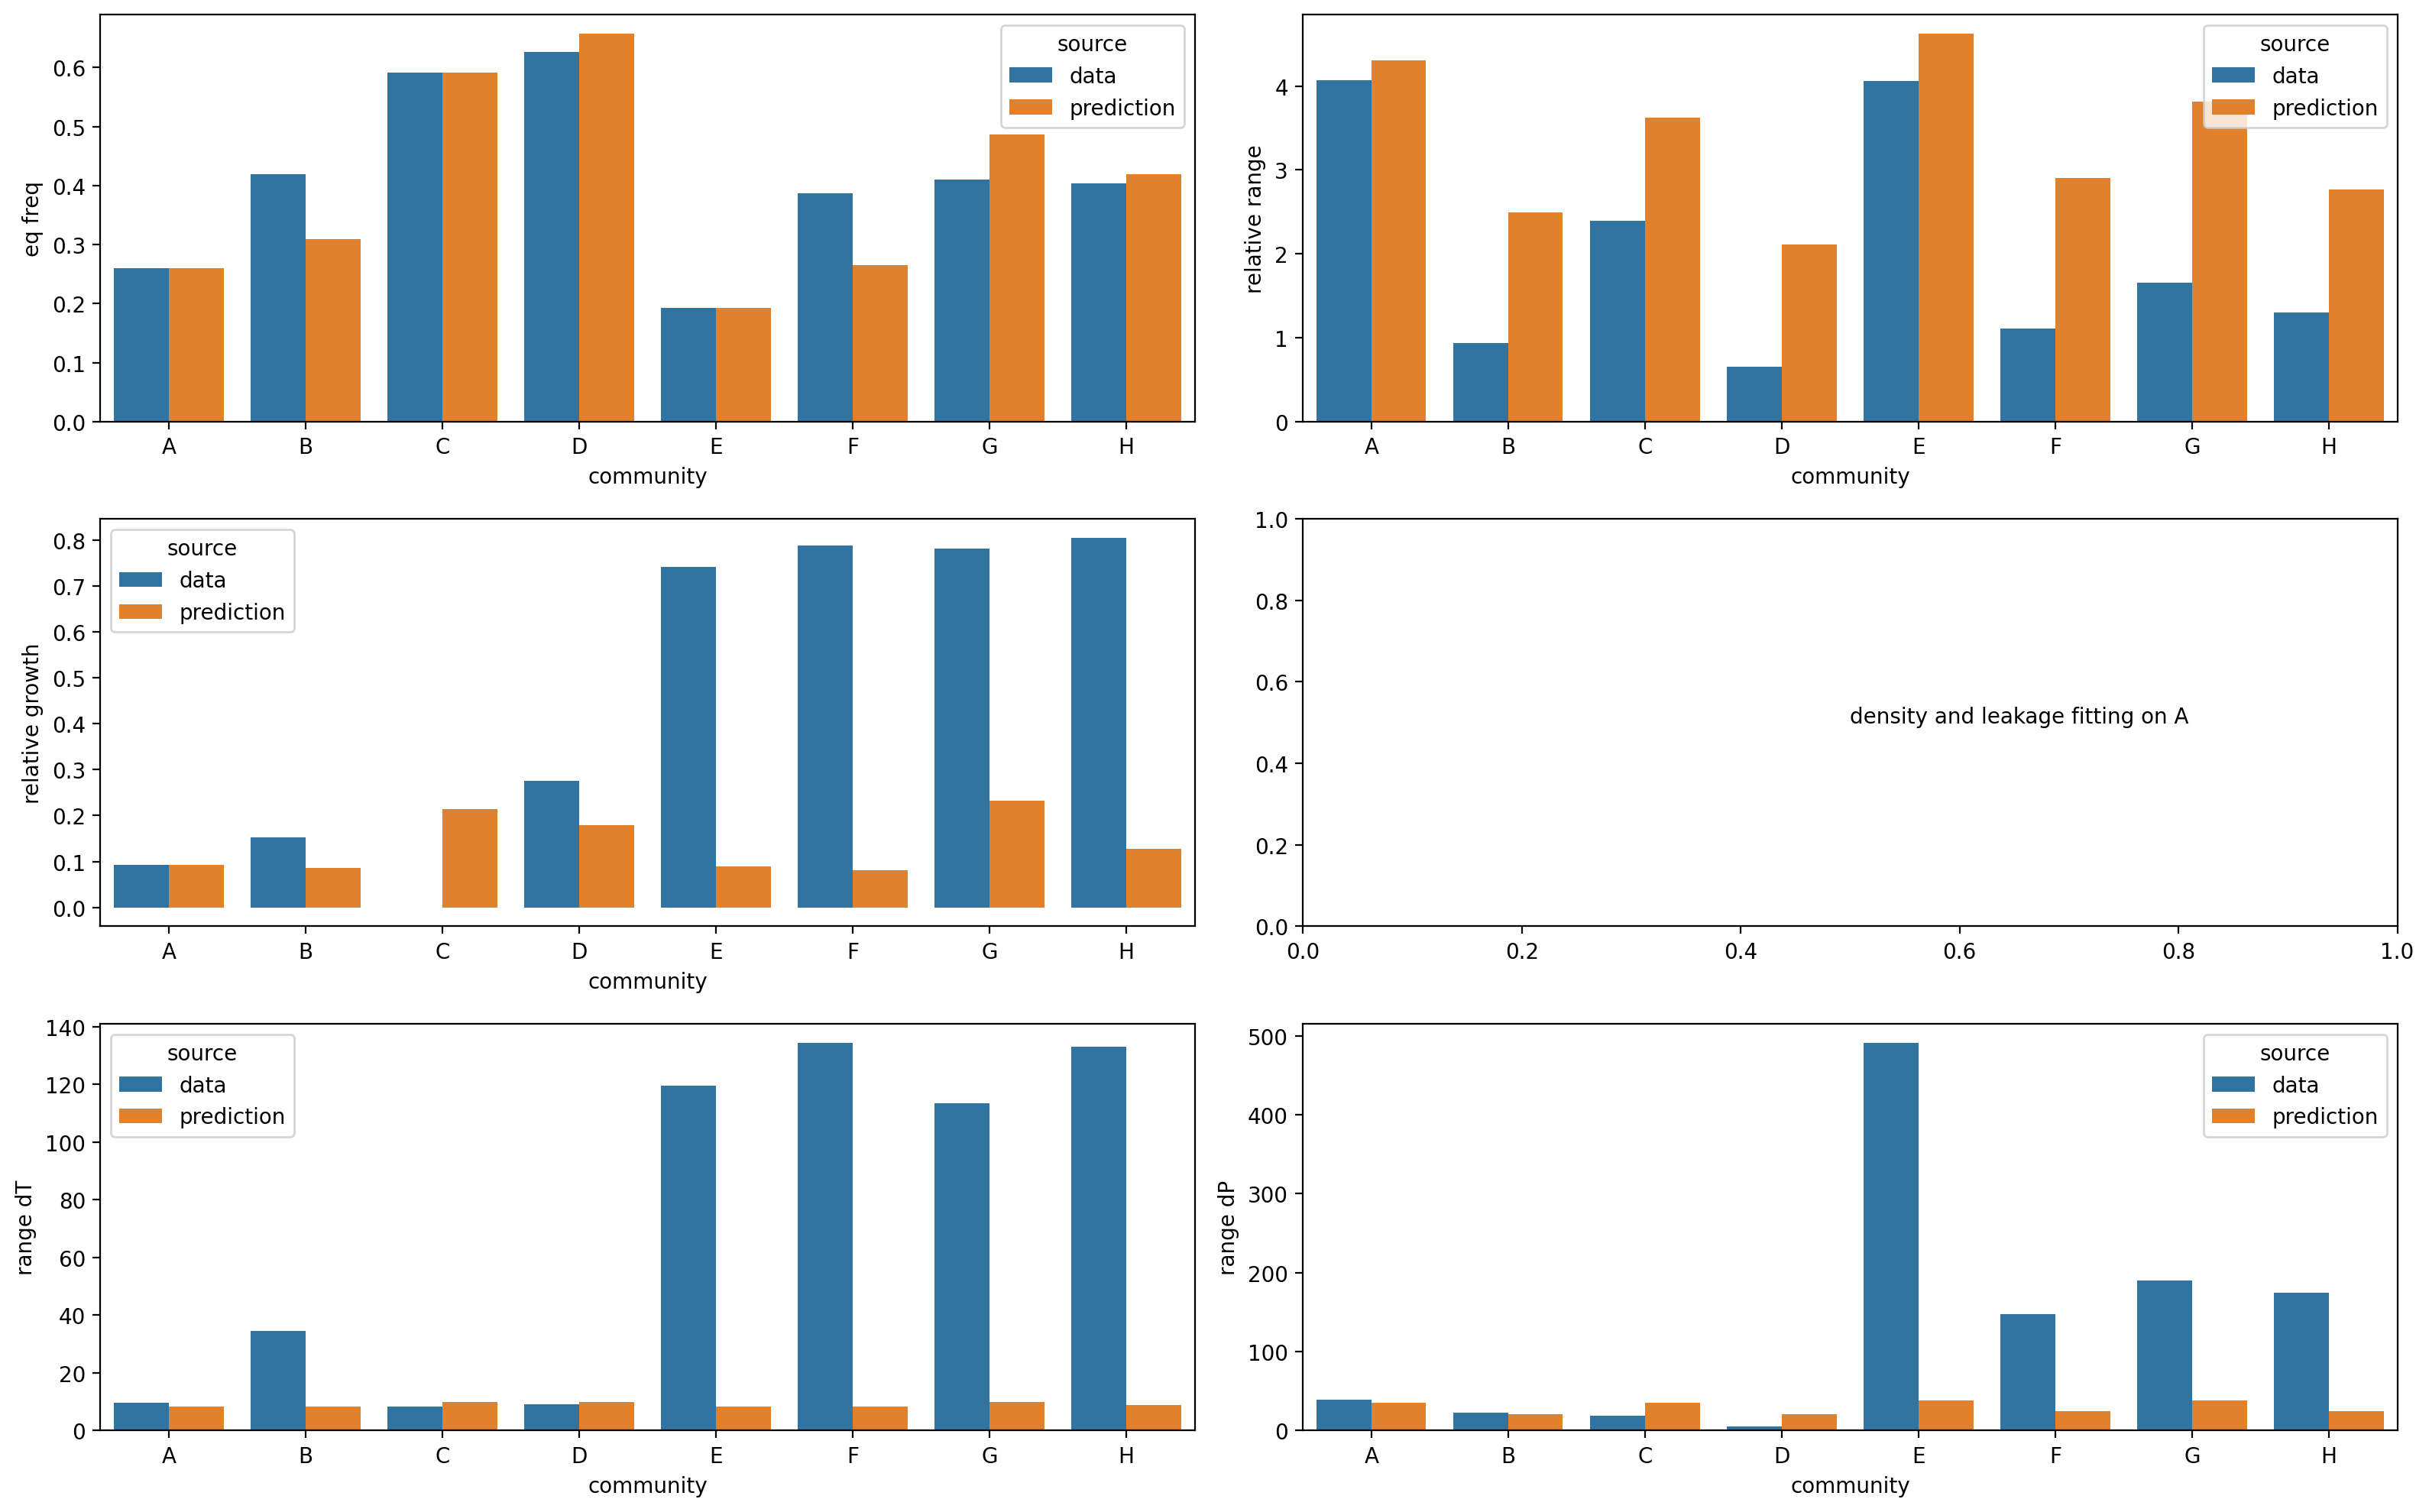

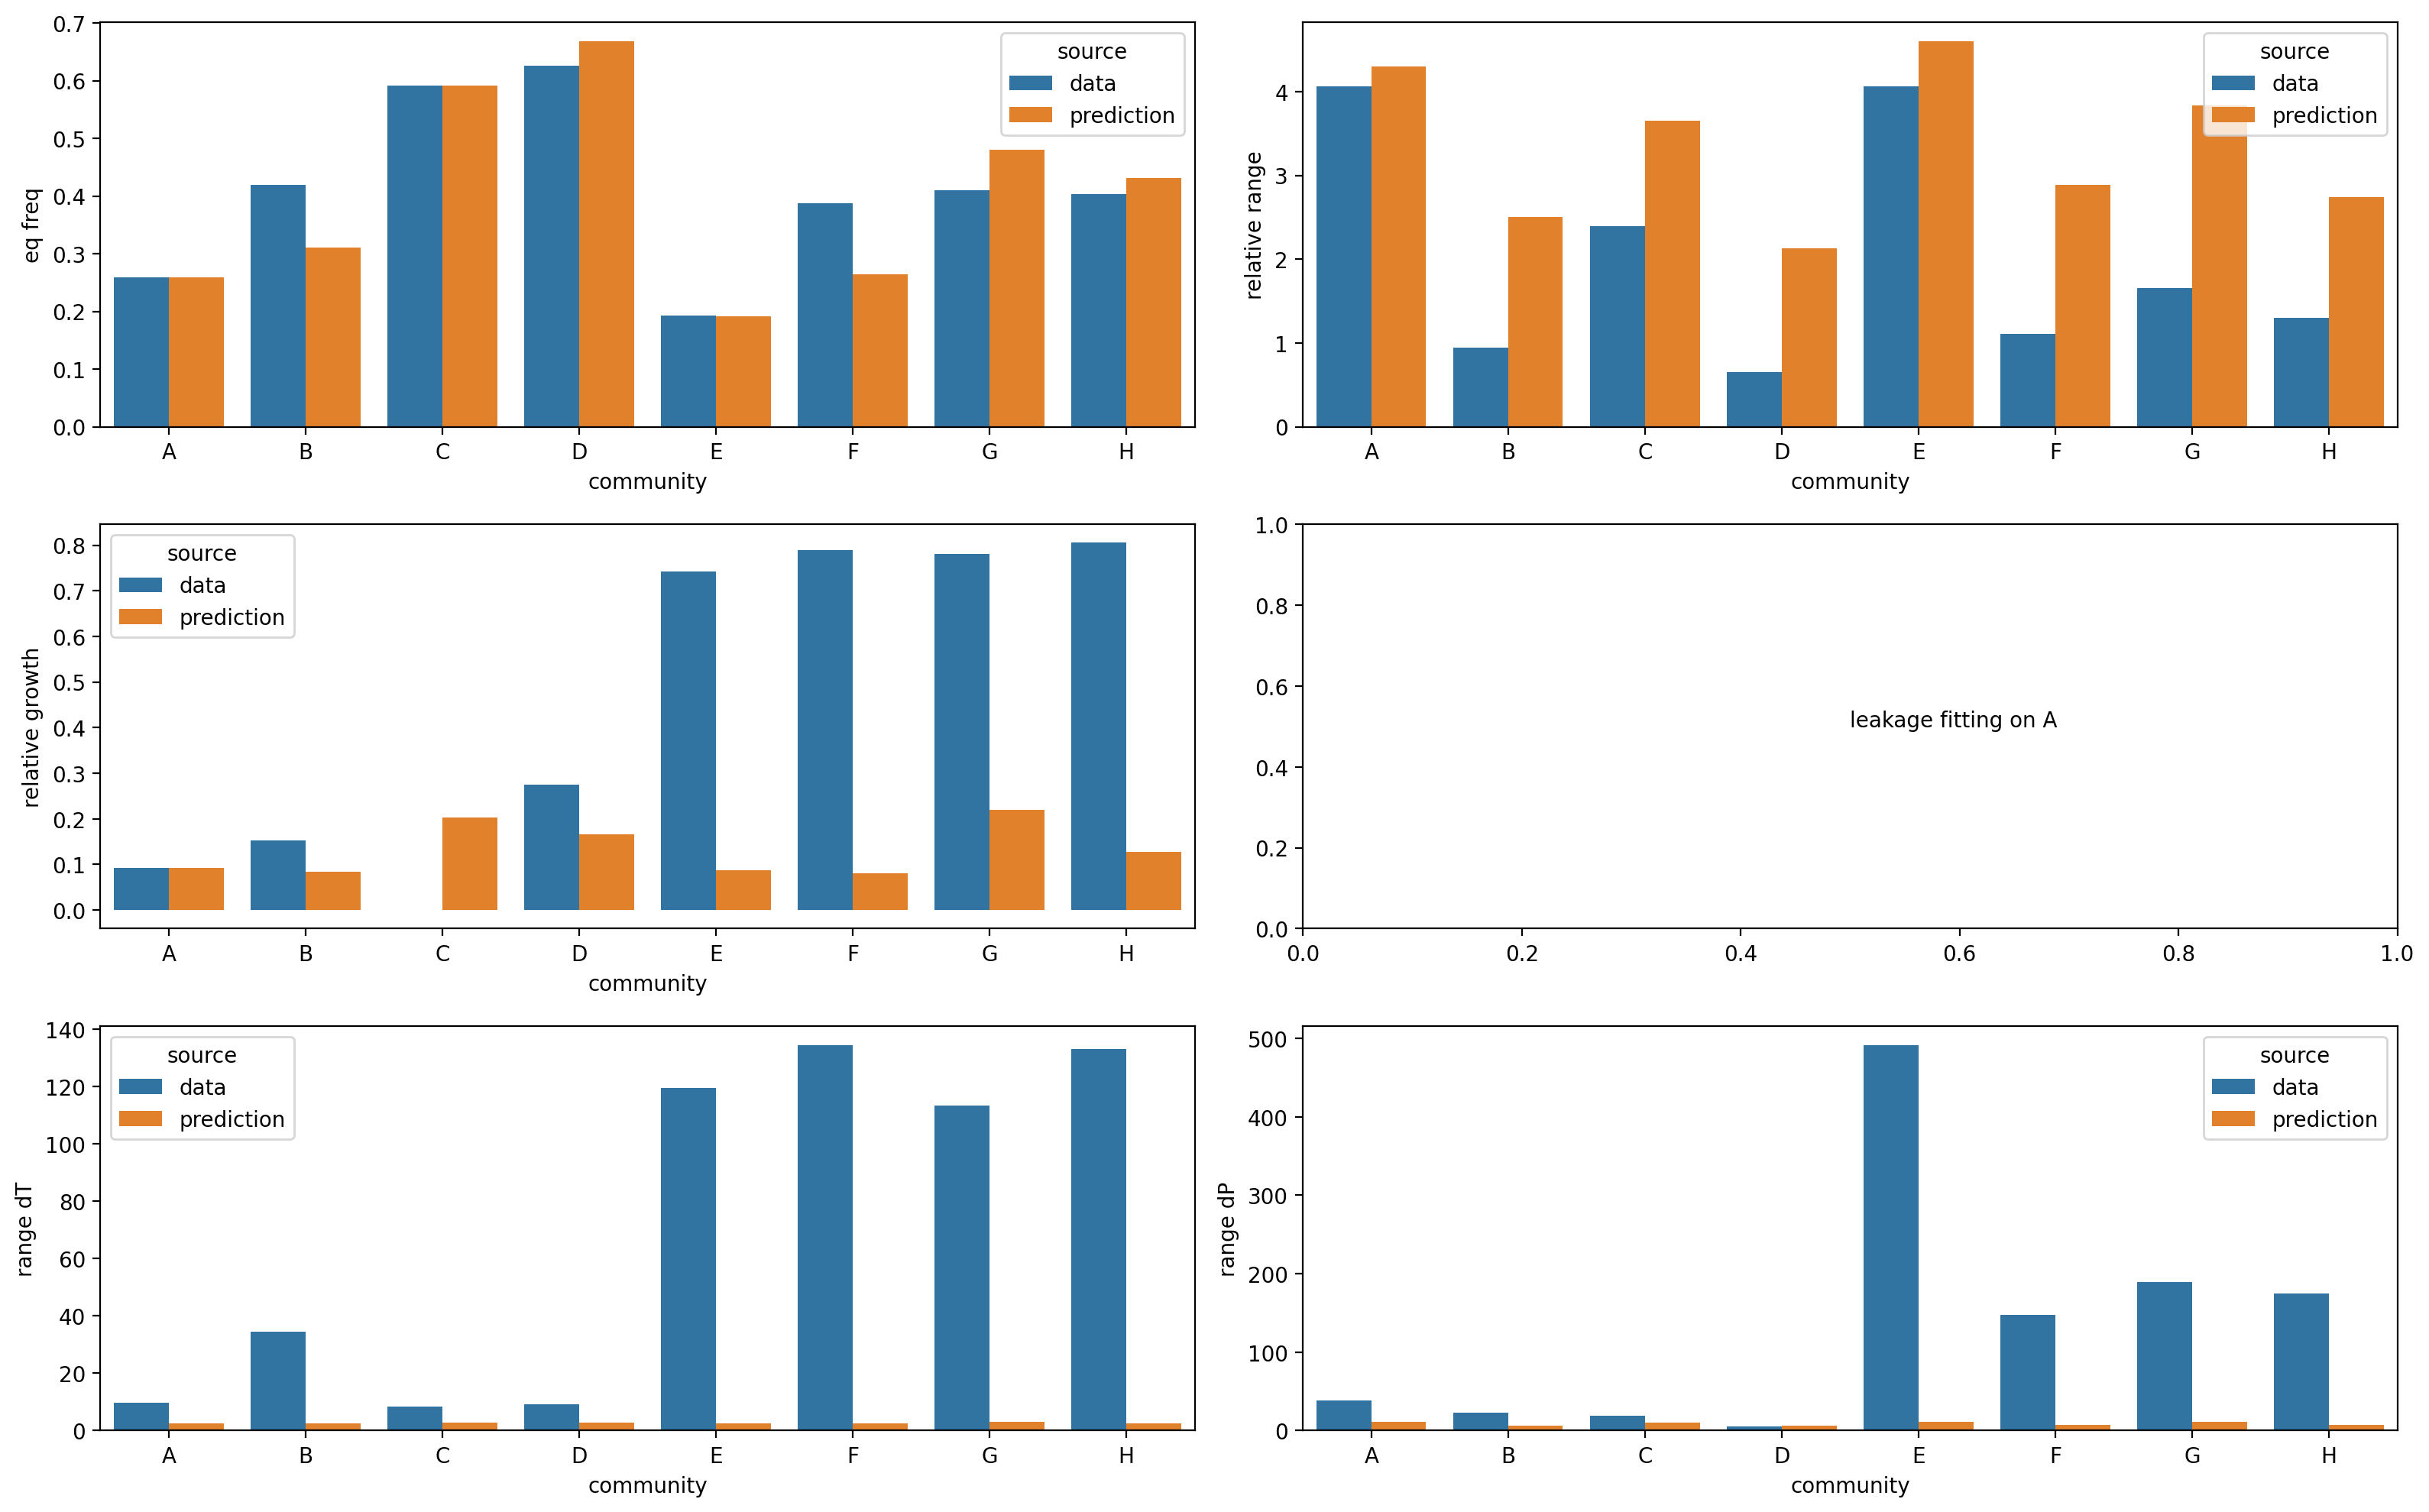

In [236]:
for df, name in zip(df_list, fit_par_name):
    plot_predictions(df, name)